# Entity Resolution project @ Wavestone
## Entity Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Run results

In [ ]:
!python result_sberts.py

Using device: cuda
/home/jovyan/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-01-22 11:16:35.574847: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF

## Import libraries

In [1]:
import os

while 'model' not in os.listdir():
    os.chdir('..')

In [2]:
import re
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from model.utils import load_data
import src.cross_encoder.result_sberts as result_sberts
import src.import_data as import_data

Using device: cpu


/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print('Available models:')
print(result_sberts.MODELS)
print()
print('Available datasets:')
print(result_sberts.DATA_NAMES)

Available models:
['cross-encoder/stsb-roberta-base', 'cross-encoder/stsb-distilroberta-base', 'cross-encoder/ms-marco-MiniLM-L-12-v2']

Available datasets:
['fodors-zagats', 'amazon-google', 'abt-buy']


In [4]:
preds = {}
results_dict = {}
for data_name in result_sberts.DATA_NAMES:
    results_dict[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    for model_name in result_sberts.MODELS:
        results_dict[data_name][model_name] = {}
        for order_cols in result_sberts.LOAD_OPTIONS['order_cols']:
            results_dict[data_name][model_name][order_cols] = {}
            for remove_col_names in result_sberts.LOAD_OPTIONS['remove_col_names']:
                dir_name = f'{data_name}-{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}'
                logits = pd.read_csv(os.path.join('results', dir_name, 'logits.csv'), names=['idA', 'idB', 'pred'])
                with open(os.path.join('results', dir_name, 'train_time.txt'), 'r') as file:
                    train_time = float(file.read().strip())
                results_dict[data_name][model_name][order_cols][remove_col_names] = {}
                results_dict[data_name][model_name][order_cols][remove_col_names]['precision'] = precision_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict[data_name][model_name][order_cols][remove_col_names]['recall'] = recall_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict[data_name][model_name][order_cols][remove_col_names]['f1'] = f1_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict[data_name][model_name][order_cols][remove_col_names]['roc_auc'] = roc_auc_score(y_test, logits['pred'].values)
                results_dict[data_name][model_name][order_cols][remove_col_names]['accuracy'] = accuracy_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict[data_name][model_name][order_cols][remove_col_names]['confusion_matrix'] = confusion_matrix(y_test, logits['pred'].values > result_sberts.threshold)
                fpr, tpr, _ = roc_curve(y_test, logits['pred'].values)
                results_dict[data_name][model_name][order_cols][remove_col_names]['roc_curve'] = (fpr, tpr, auc(fpr, tpr))
                results_dict[data_name][model_name][order_cols][remove_col_names]['logits'] = logits
                results_dict[data_name][model_name][order_cols][remove_col_names]['train_time'] = train_time

Table A columns:
  column_name              data_example
1        addr  '435 s. la cienega blv.'
2        city             'los angeles'
3       phone              310/246-1501
4        type                  american 

Table B columns:
  column_name           data_example
1        addr  '10801 w. pico blvd.'
2        city              'west la'
3       phone           310-475-3585
4        type               american 

Serialized entities 

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Serialized entities 

Table A columns:
   column_name                                       data_example
1  description  Sony Turntable - PSLX350H/ Belt Drive System/ ...
2        price                                                

In [5]:
for data_name, models in results_dict.items():
    best_f1 = 0
    best_option = None
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                if metrics['f1'] > best_f1:
                    best_f1 = metrics['f1']
                    best_option = (model_name, order_cols, remove_col_names)
    print(f"Dataset: {data_name}, Best F1 Score: {best_f1}, Options: {best_option}")

Dataset: fodors-zagats, Best F1 Score: 1.0, Options: ('cross-encoder/stsb-roberta-base', True, True)
Dataset: amazon-google, Best F1 Score: 0.9034749034749034, Options: ('cross-encoder/stsb-roberta-base', False, True)
Dataset: abt-buy, Best F1 Score: 0.9488372093023256, Options: ('cross-encoder/stsb-roberta-base', False, False)


In [6]:
for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                print(f"Dataset: {data_name}, Model: {model_name}, Order Cols: {order_cols}, Remove Col Names: {remove_col_names}")
                print(f"Precision: {metrics['precision']}")
                print(f"Recall: {metrics['recall']}")
                print(f"F1: {metrics['f1']}")
                print(f"ROC AUC: {metrics['roc_auc']}")
                print(f"Accuracy: {metrics['accuracy']}")
                print(f"Confusion Matrix: {metrics['confusion_matrix']}")
                print(f"Train Time: {metrics['train_time']}")
                print()

Dataset: fodors-zagats, Model: cross-encoder/stsb-roberta-base, Order Cols: True, Remove Col Names: True
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0
Accuracy: 1.0
Confusion Matrix: [[55  0]
 [ 0 11]]
Train Time: 11.365642547607422

Dataset: fodors-zagats, Model: cross-encoder/stsb-roberta-base, Order Cols: True, Remove Col Names: False
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0
Accuracy: 1.0
Confusion Matrix: [[55  0]
 [ 0 11]]
Train Time: 17.75144100189209

Dataset: fodors-zagats, Model: cross-encoder/stsb-roberta-base, Order Cols: False, Remove Col Names: True
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0
Accuracy: 1.0
Confusion Matrix: [[55  0]
 [ 0 11]]
Train Time: 10.627101421356201

Dataset: fodors-zagats, Model: cross-encoder/stsb-roberta-base, Order Cols: False, Remove Col Names: False
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0
Accuracy: 1.0
Confusion Matrix: [[55  0]
 [ 0 11]]
Train Time: 17.763076782226562

Dataset: fodors-zagats, Model: cross-encoder/stsb-dis

## Visualisation

### 1. Bar Chart for Model Comparison

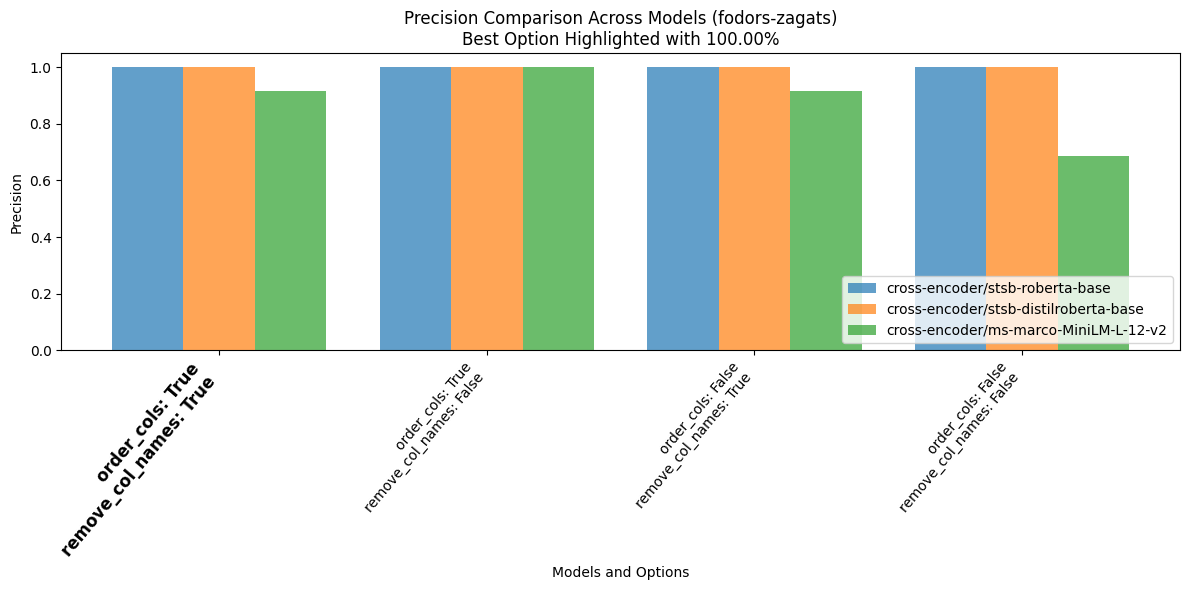

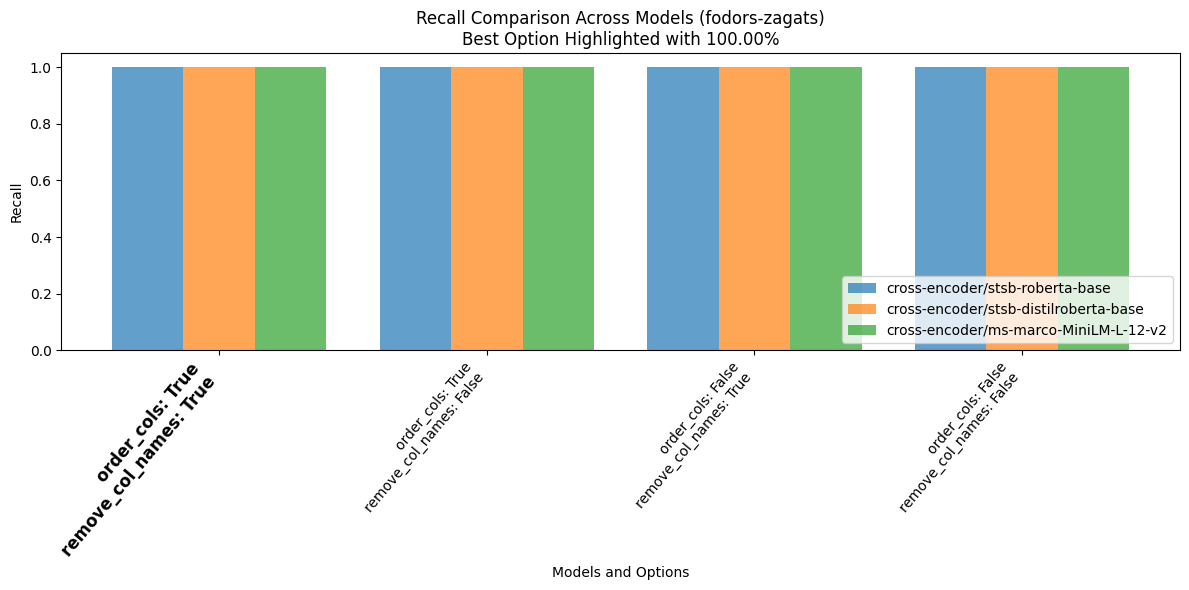

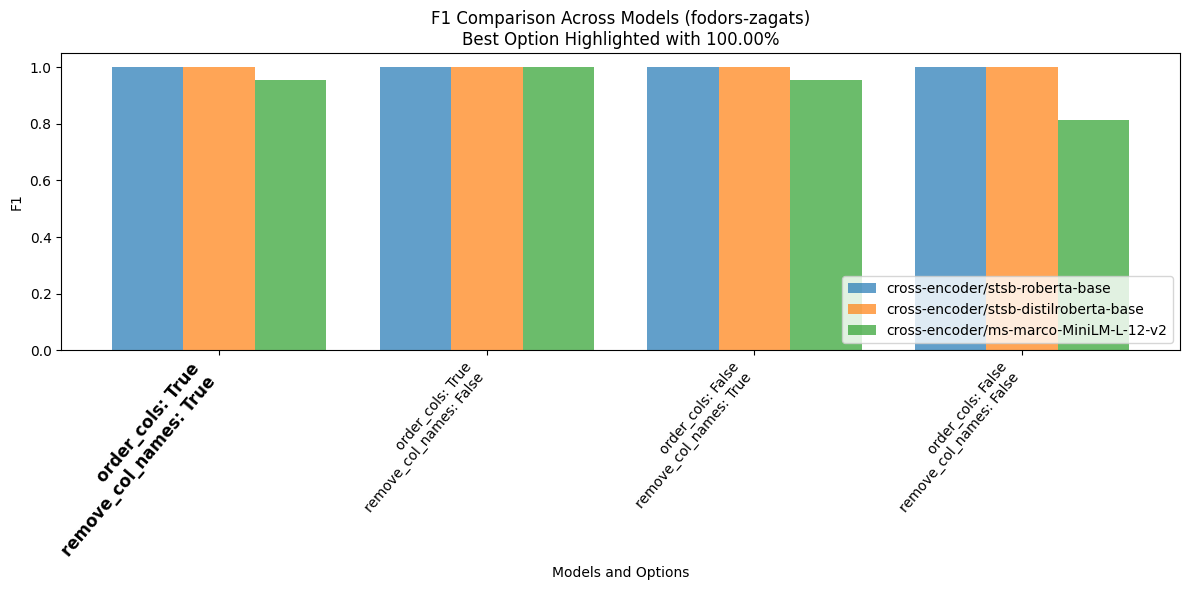

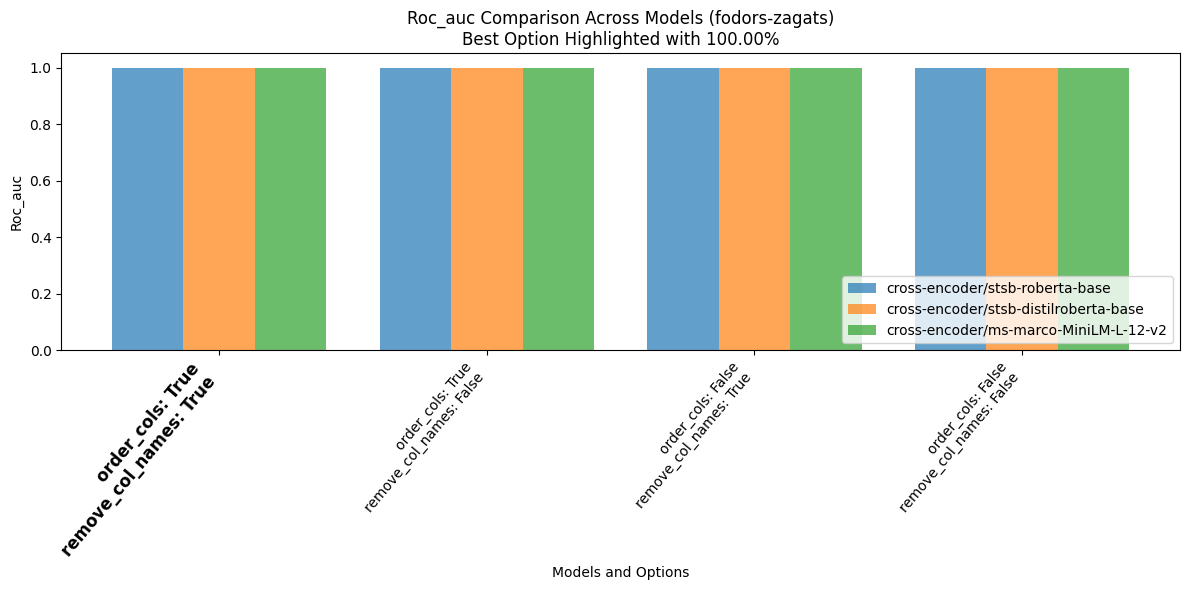

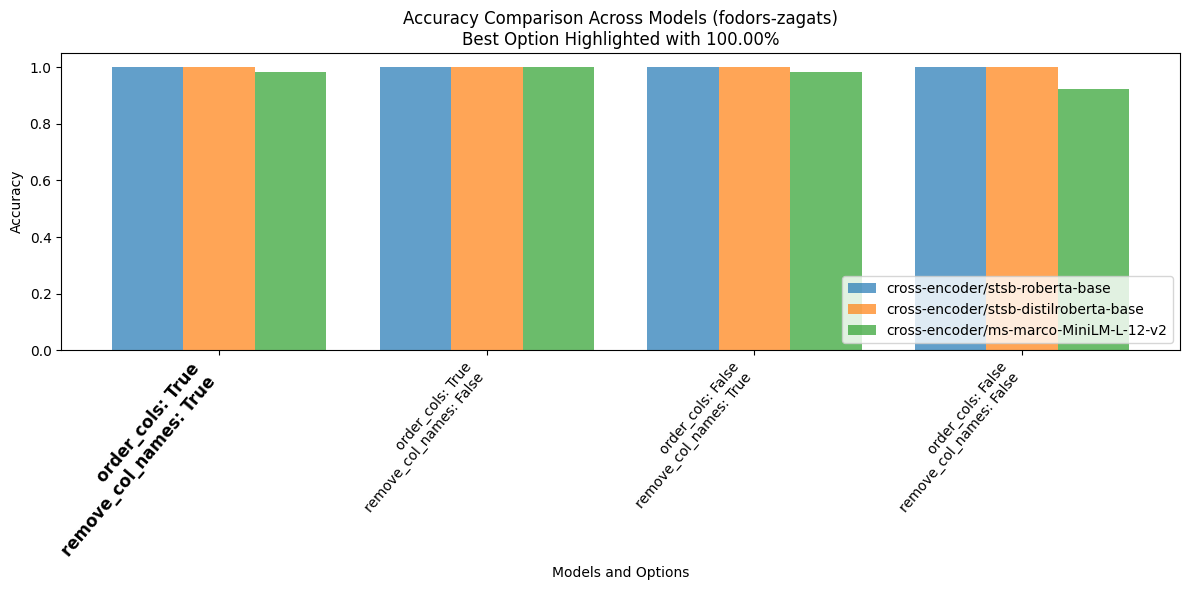

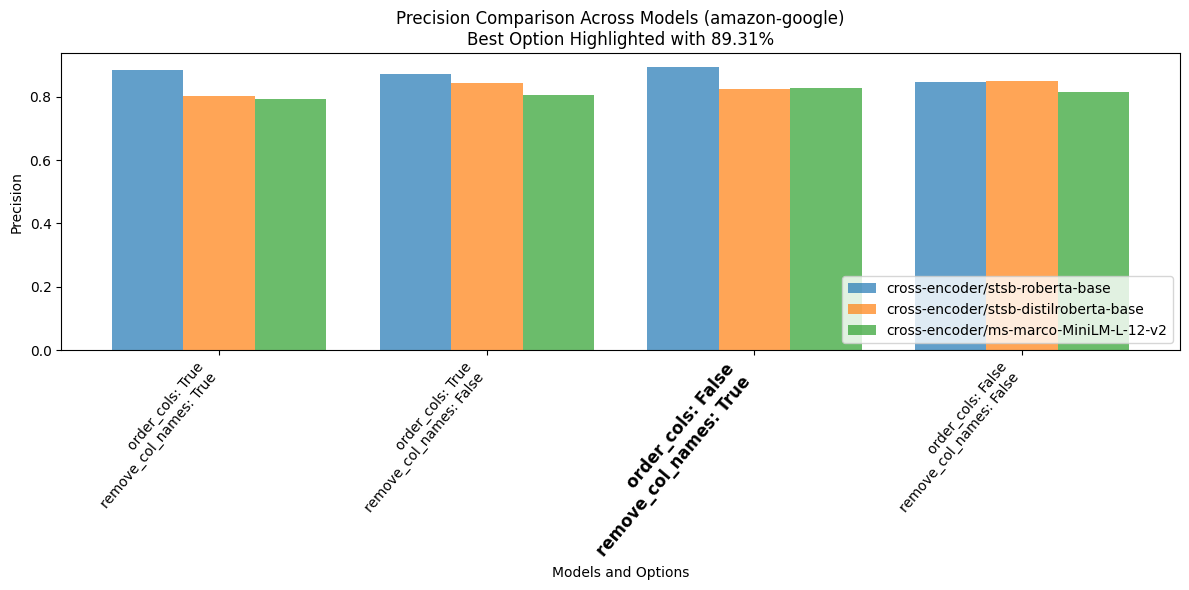

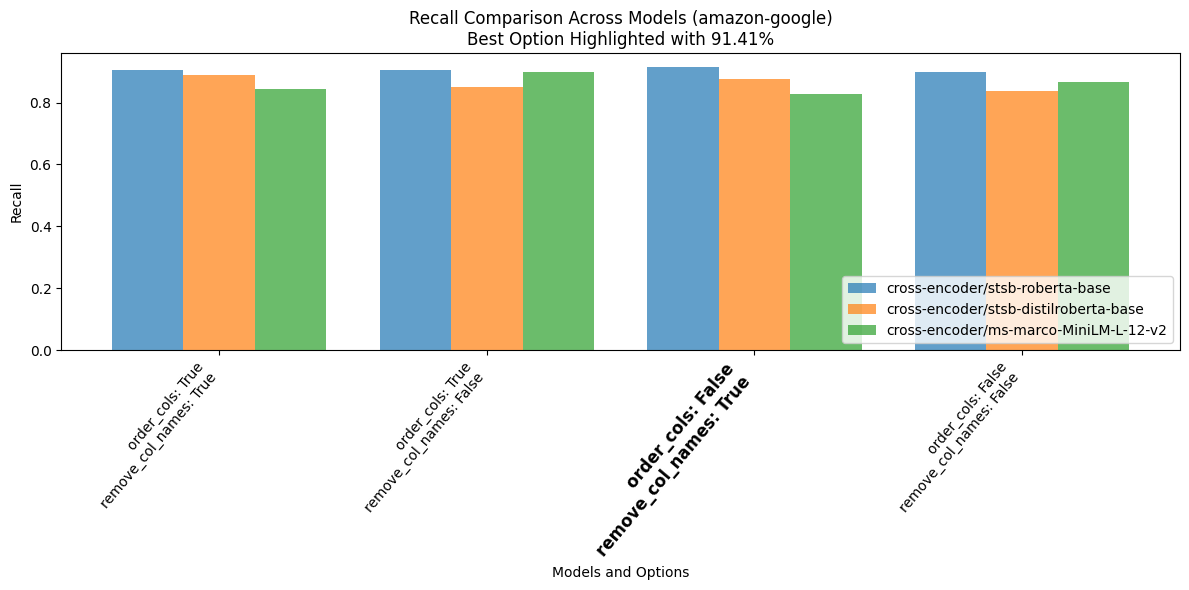

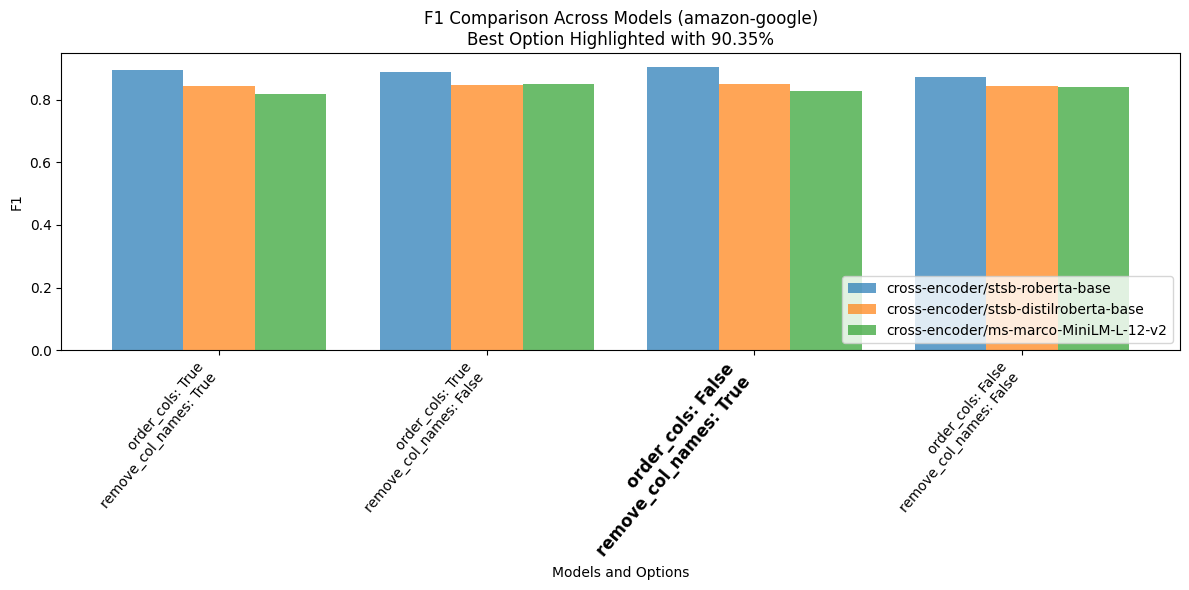

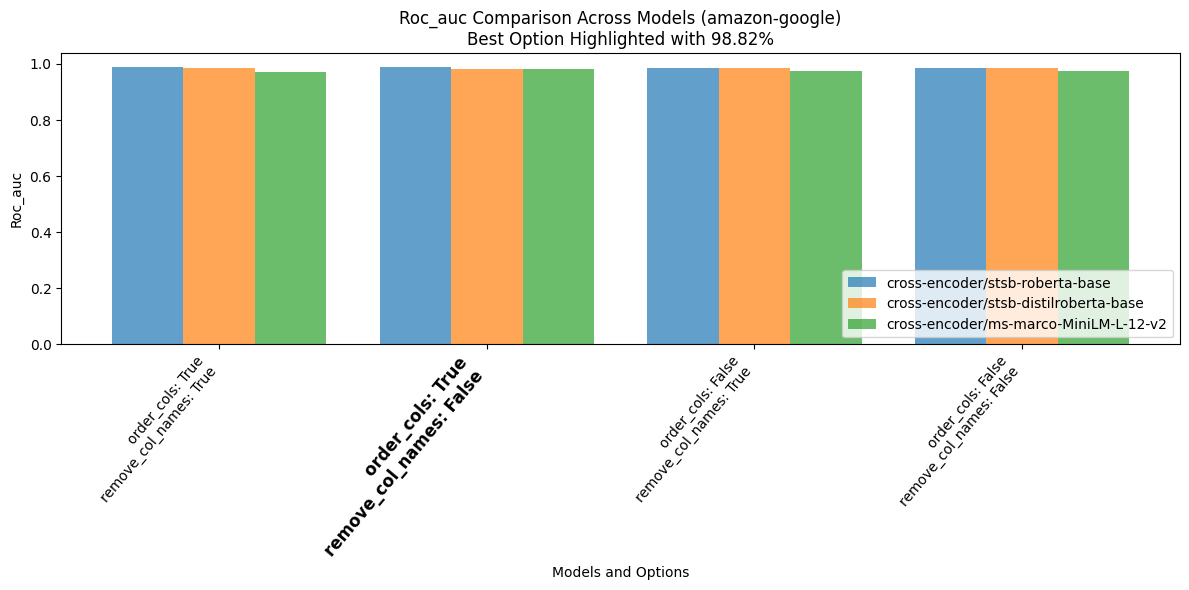

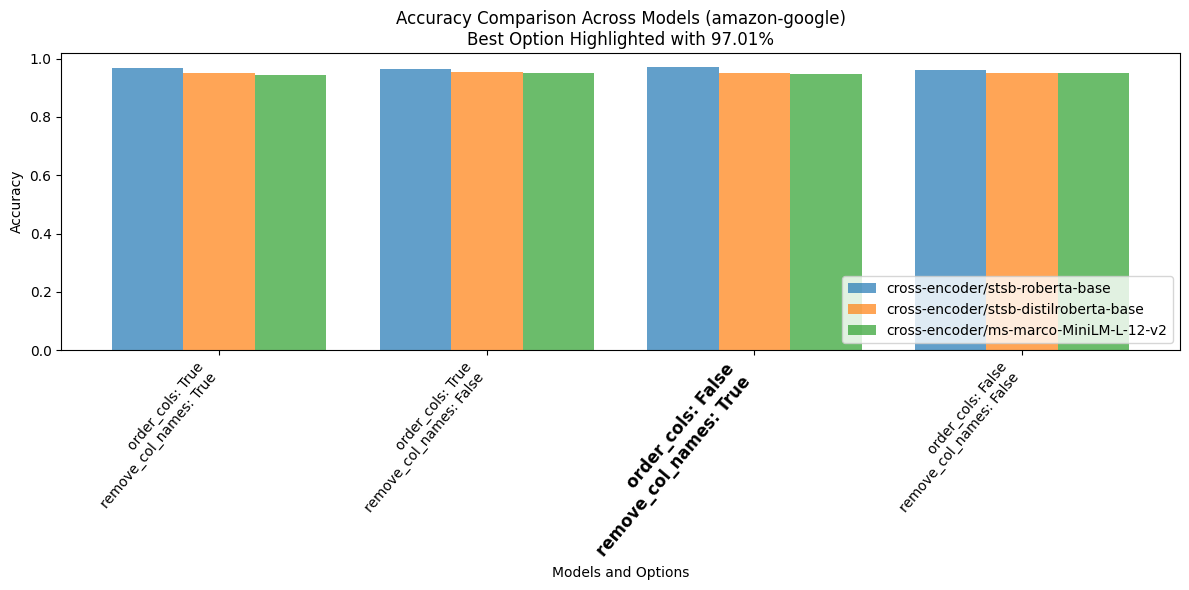

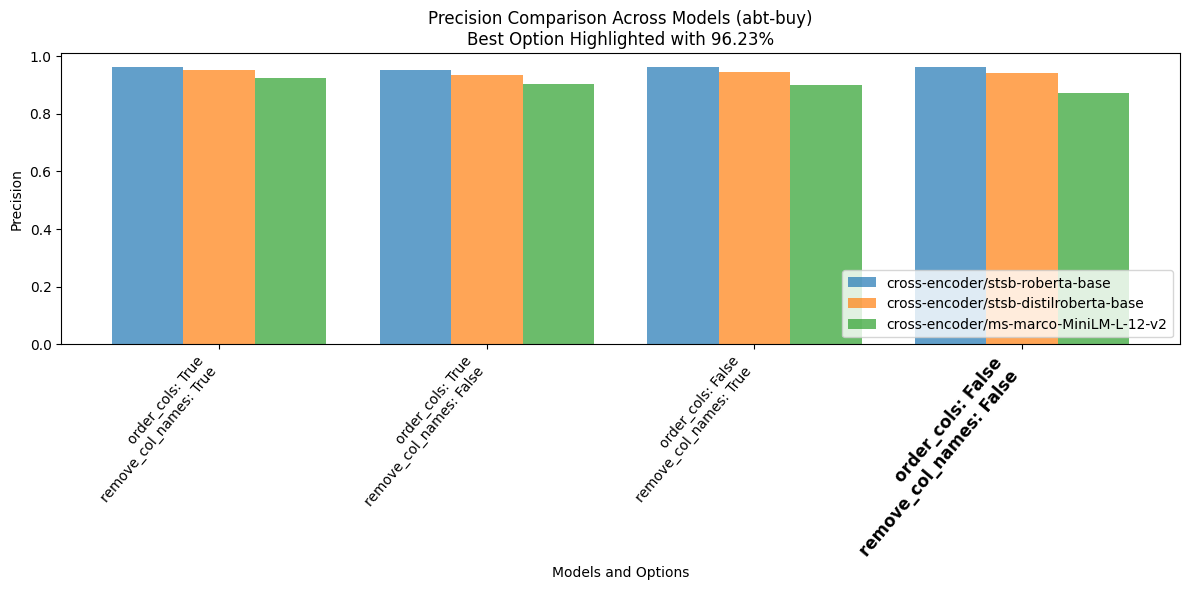

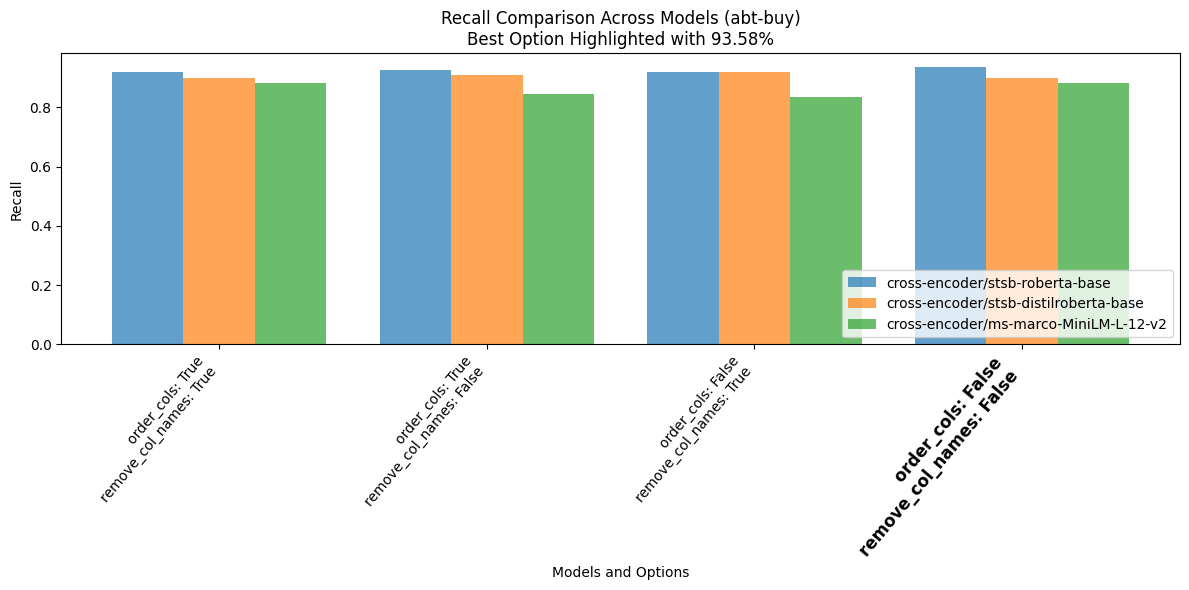

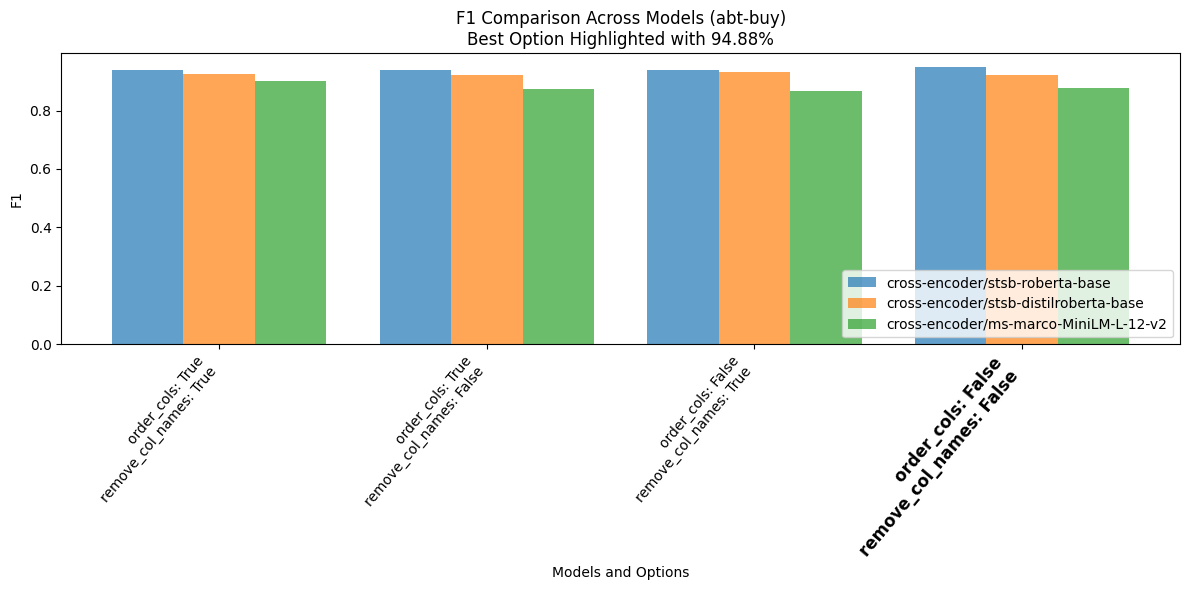

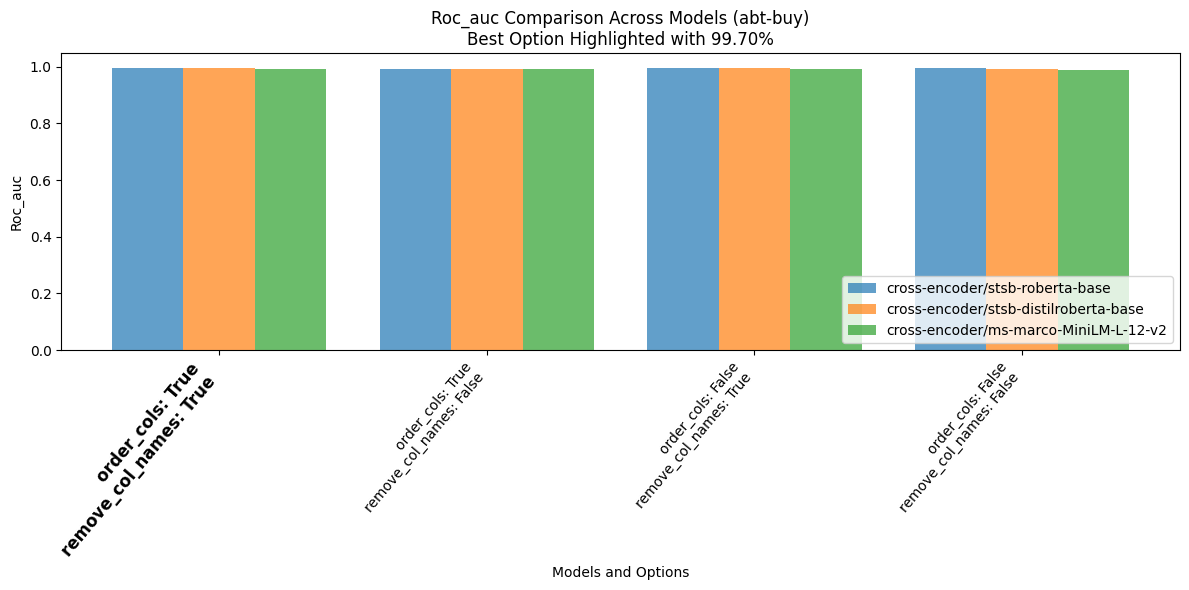

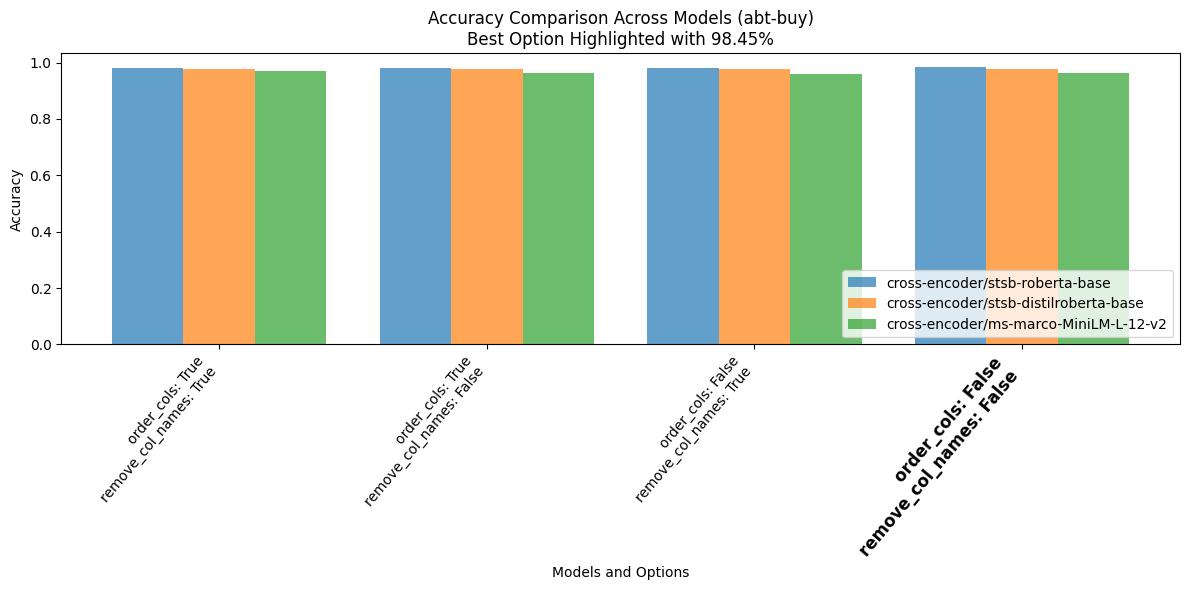

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data
metrics_list = ['precision', 'recall', 'f1', 'roc_auc', 'accuracy']
datasets = results_dict.keys()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for data_name in datasets:
    for metric in metrics_list:
        fig, ax = plt.subplots(figsize=(12, 6))
        model_names = list(results_dict[data_name].keys())
        num_models = len(model_names)
        values = [[] for _ in range(num_models)]
        labels = []
        color_map = []
        for model_idx, model_name in enumerate(model_names):
            for order_cols in results_dict[data_name][model_name].keys():
                for remove_col_names in results_dict[data_name][model_name][order_cols].keys():
                    if model_idx == 0:
                        labels.append(f"order_cols: {order_cols}\nremove_col_names: {remove_col_names}")
                    values[model_idx].append(results_dict[data_name][model_name][order_cols][remove_col_names][metric])
                    color_map.append(colors[model_idx % len(colors)])
        
        x = np.arange(len(labels))
        bar_width = 0.8 / num_models  # Adjust the width of the bars
        for i in range(num_models):
            ax.bar(x + i * bar_width, values[i], bar_width, color=colors[i % len(colors)], alpha=0.7, label=model_names[i])
        
        ax.set_xticks(x + bar_width * (num_models - 1) / 2)
        ax.set_xticklabels(labels, rotation=50, ha='right')
        ax.set_title(f"{metric.capitalize()} Comparison Across Models ({data_name})\nBest Option Highlighted with {max(max(values)):.2%}")
        ax.set_xlabel("Models and Options")
        ax.set_ylabel(metric.capitalize())
        ax.legend(loc='lower right')
        
        # Highlight the best option
        best_option_idx = np.argmax([max(values[i]) for i in range(num_models)])
        best_label_idx = np.argmax(values[best_option_idx])
        ax.get_xticklabels()[best_label_idx].set_fontweight('bold')
        ax.get_xticklabels()[best_label_idx].set_fontsize(12)
        
        plt.tight_layout()
        plt.show()


### 2. Confusion Matrix Heatmap

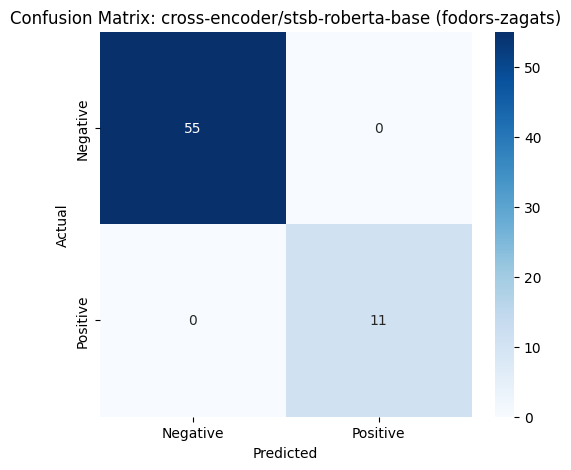

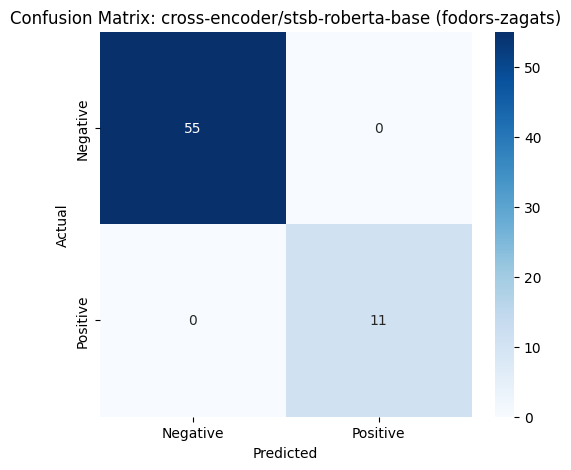

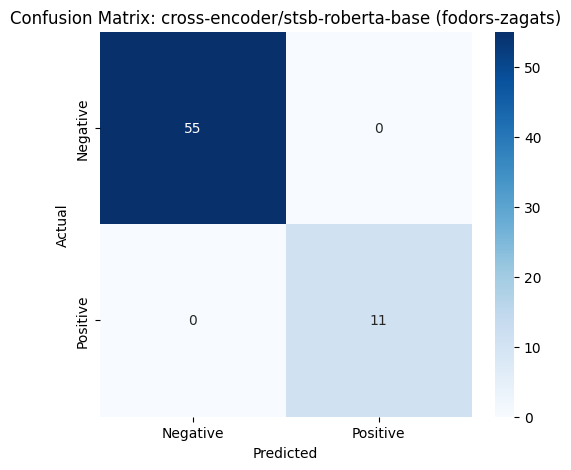

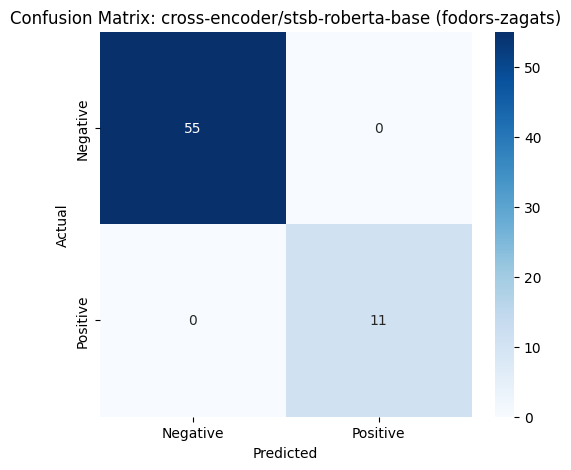

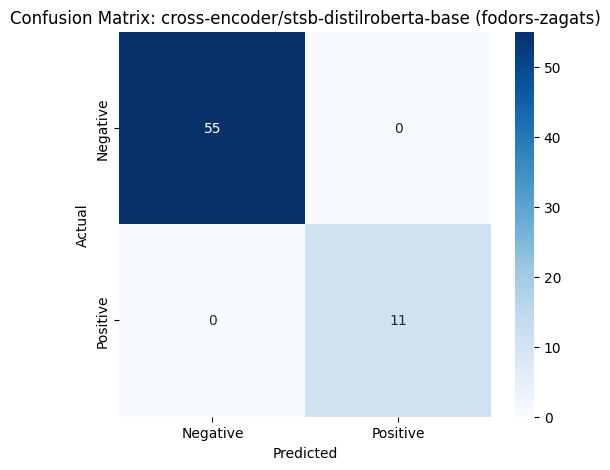

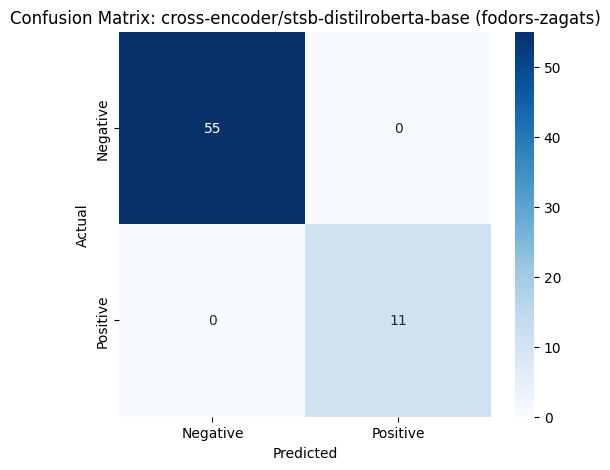

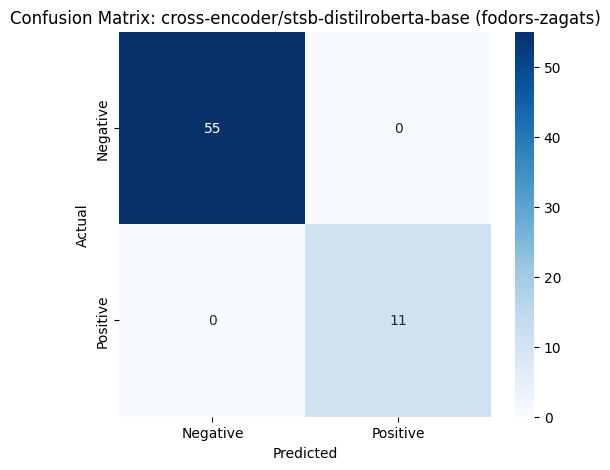

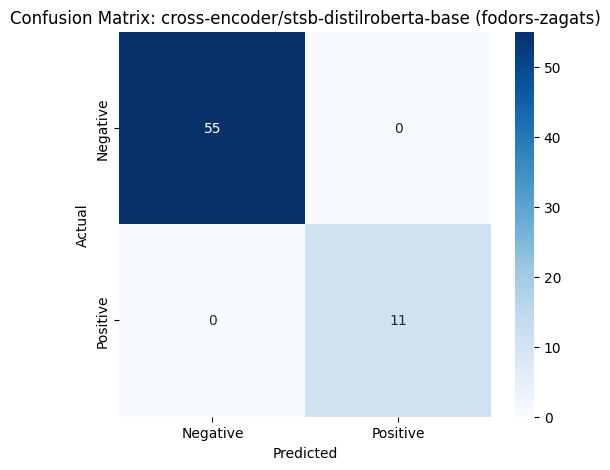

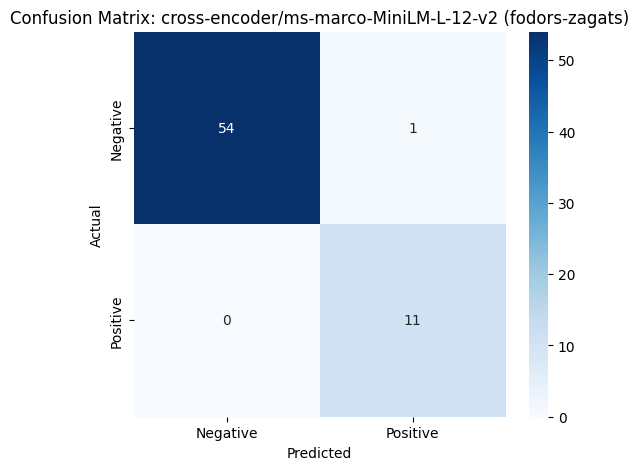

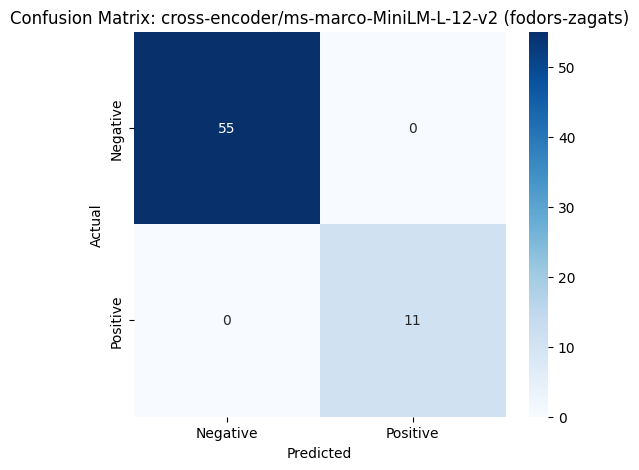

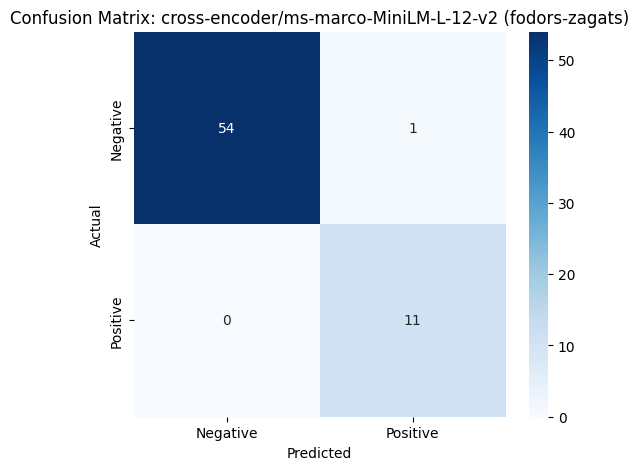

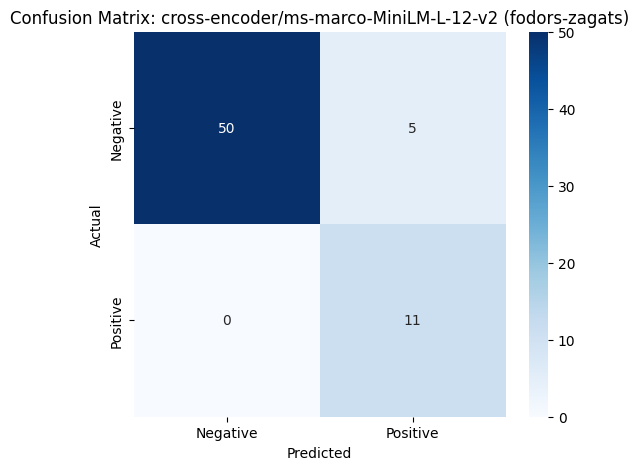

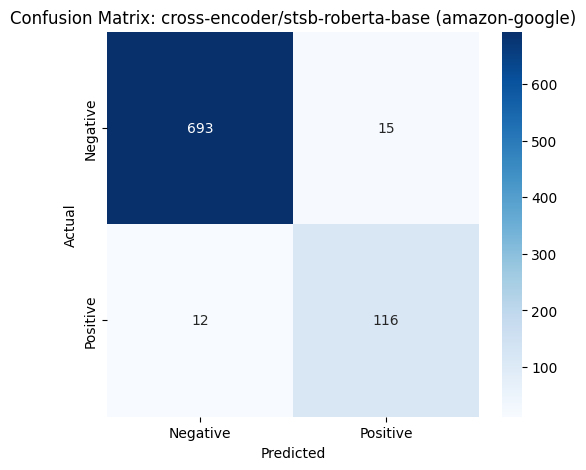

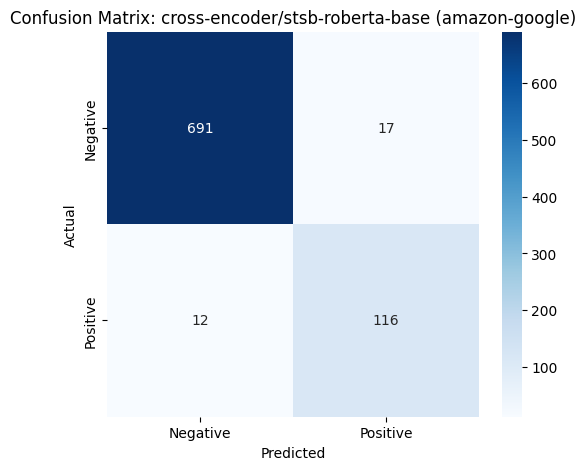

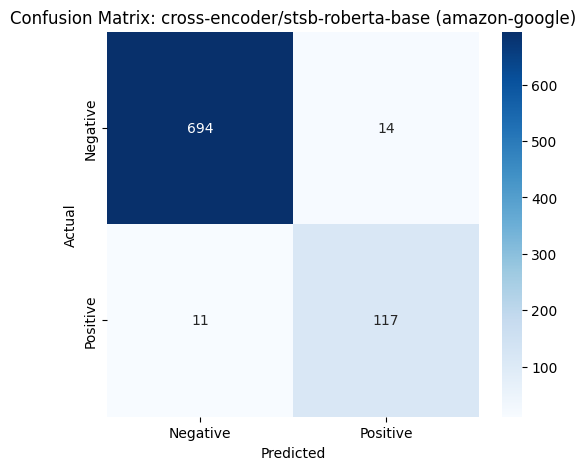

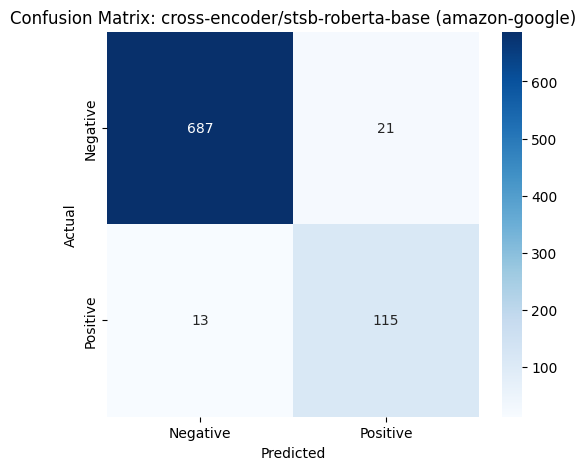

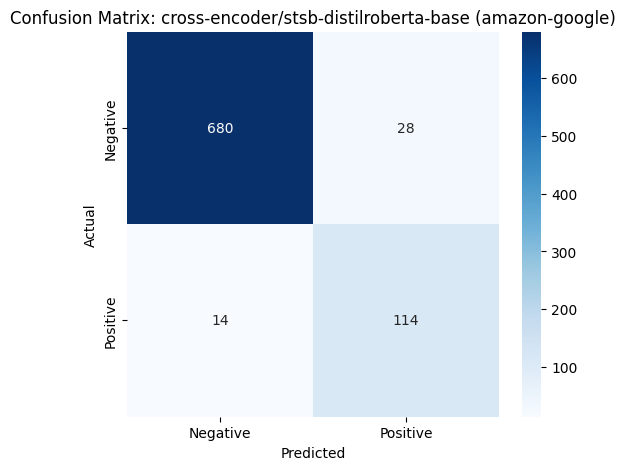

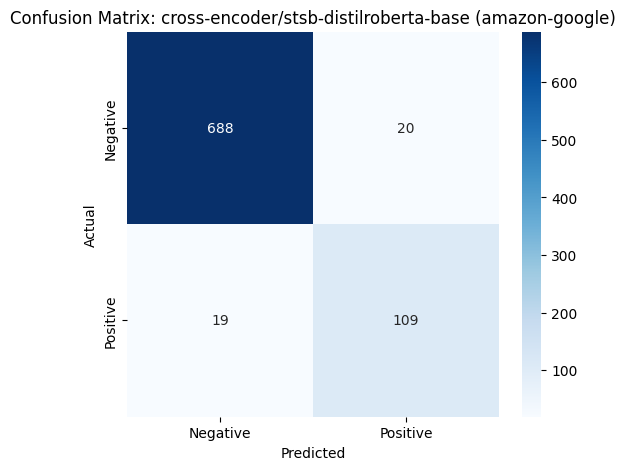

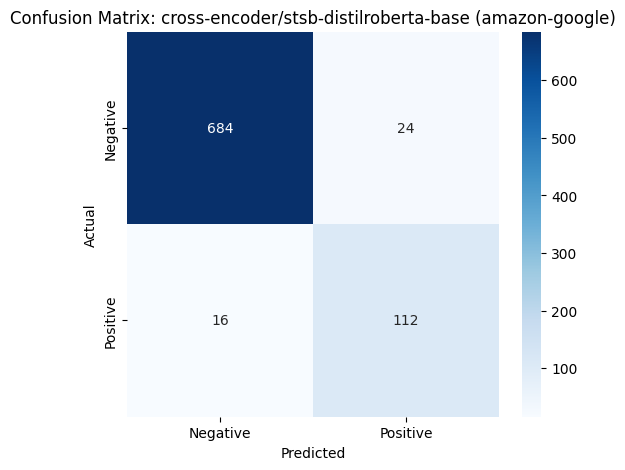

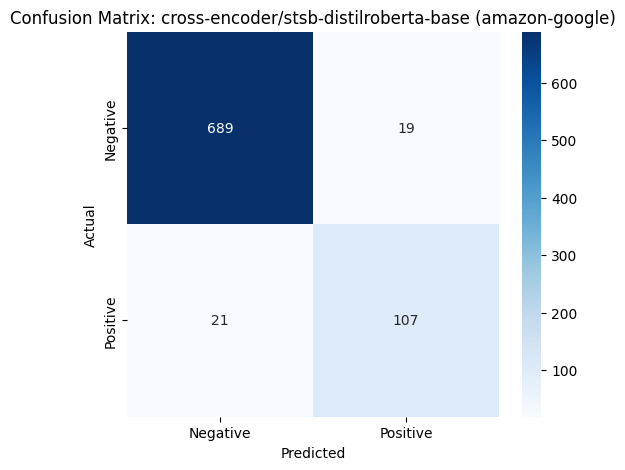

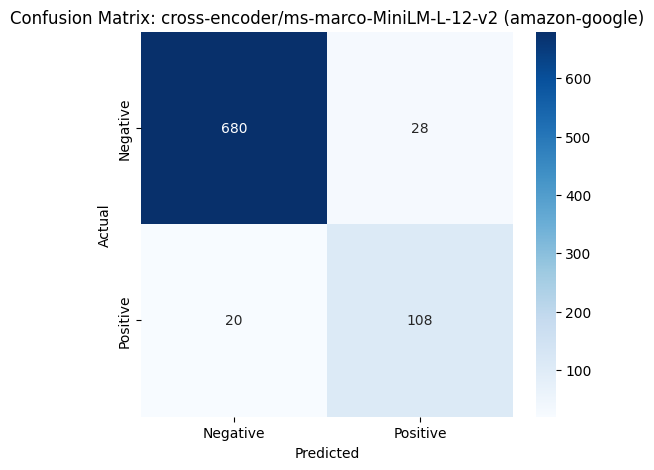

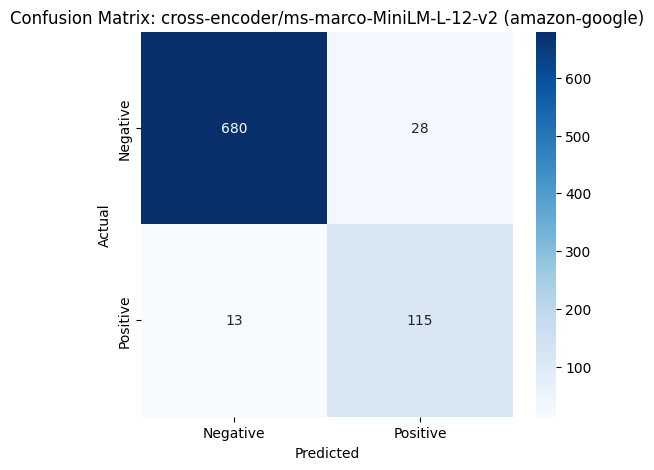

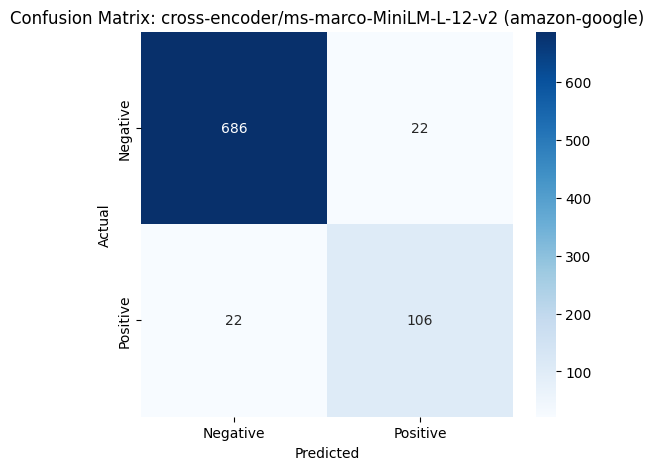

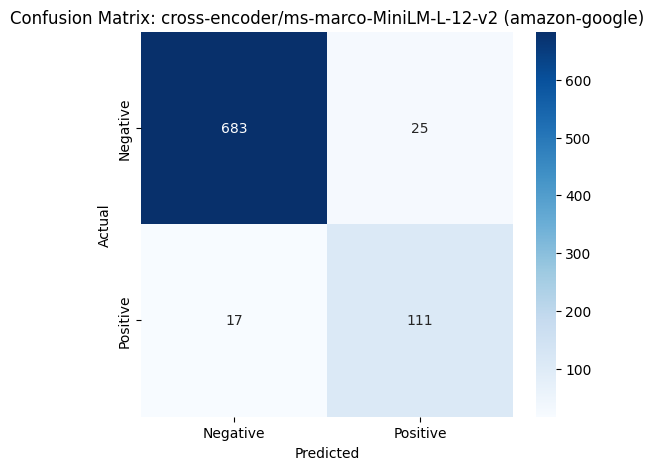

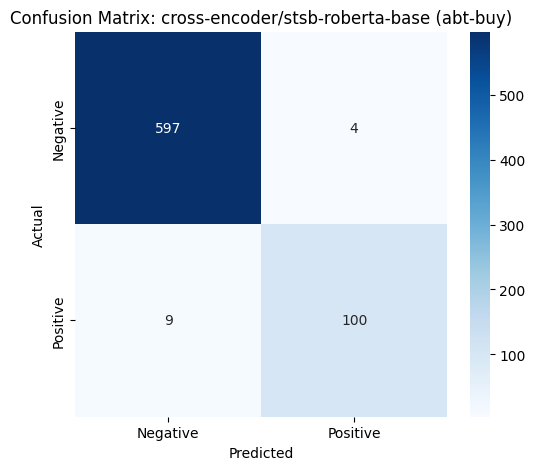

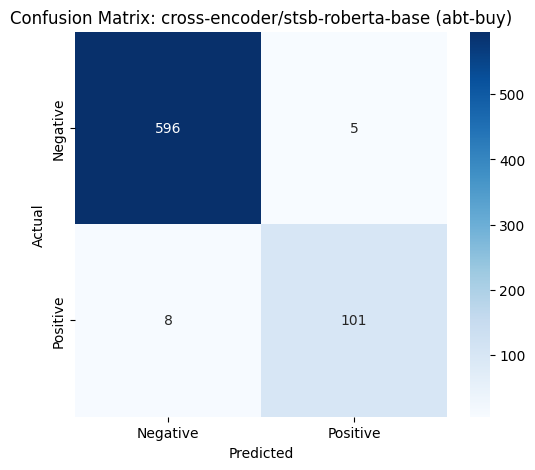

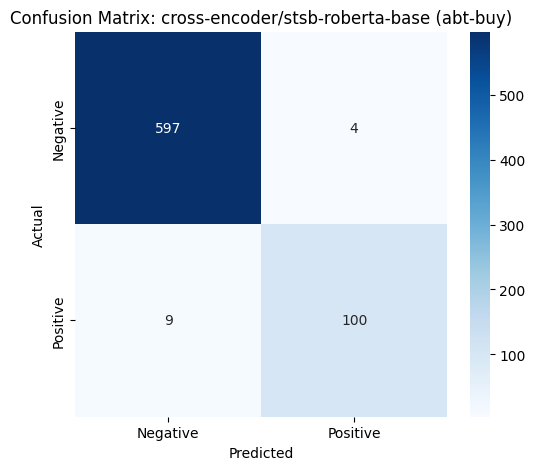

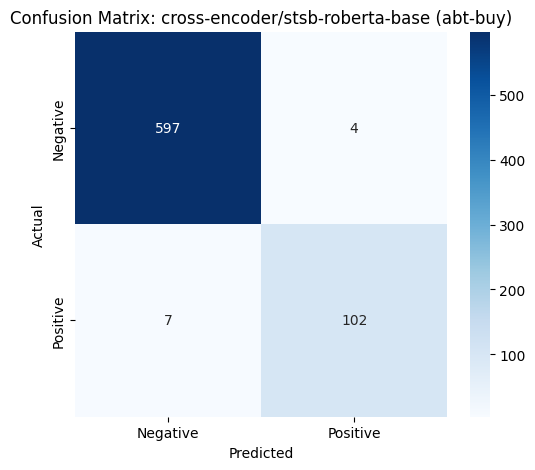

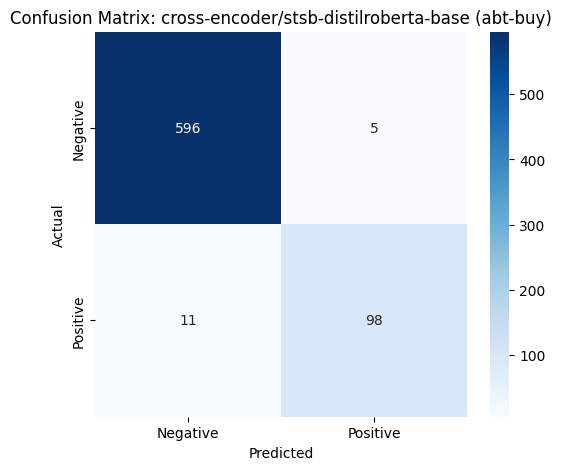

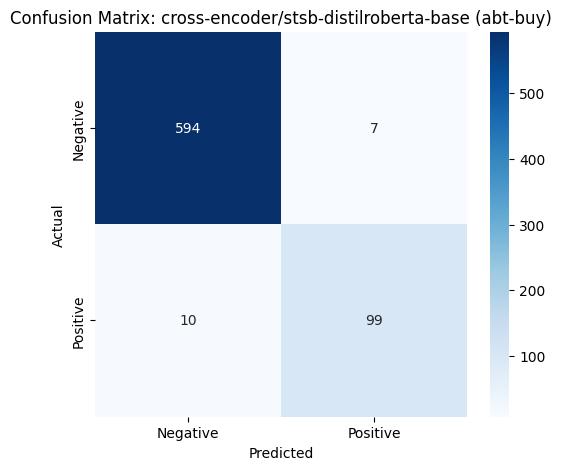

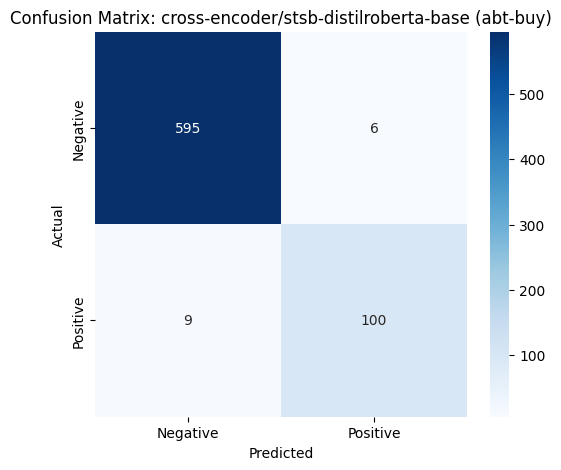

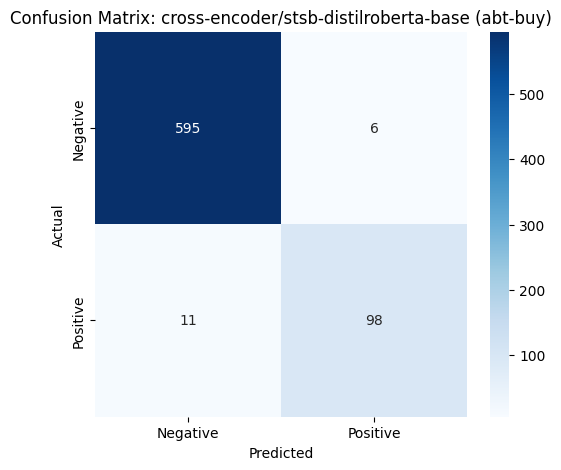

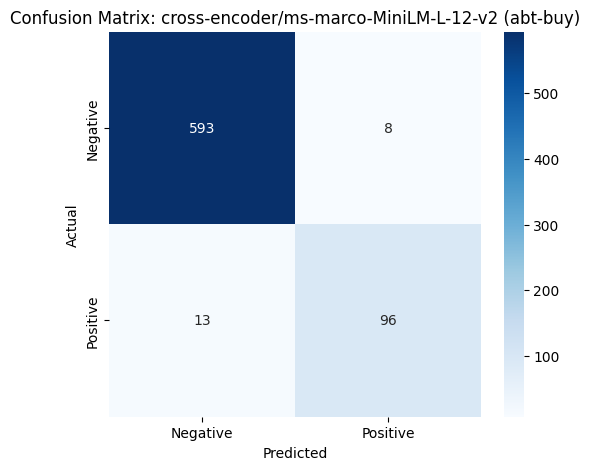

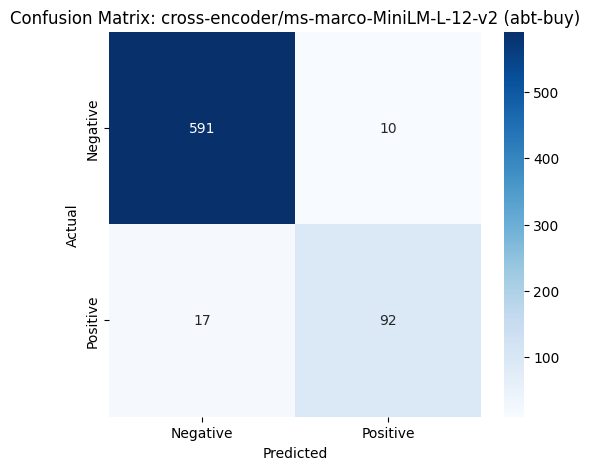

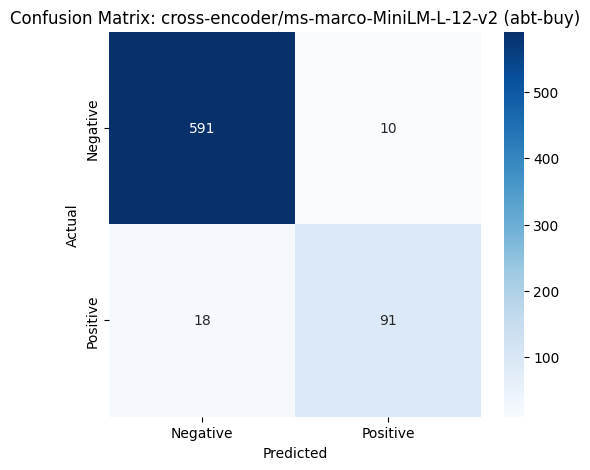

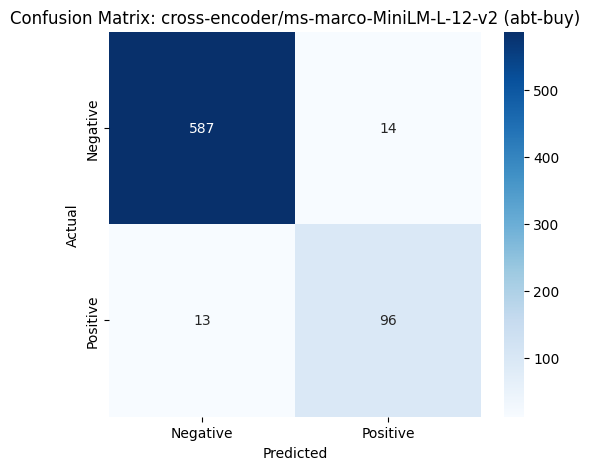

In [8]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                cm = np.array(metrics["confusion_matrix"])
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
                plt.xlabel("Predicted")
                plt.ylabel("Actual")
                plt.title(f"Confusion Matrix: {model_name} ({data_name})")
                plt.show()

### 3. ROC Curve for Classification Models

<Figure size 1000x600 with 0 Axes>

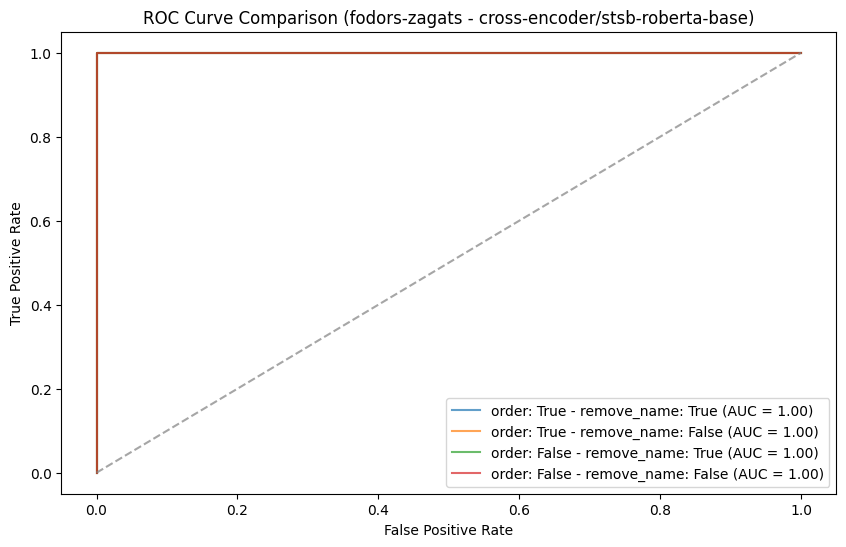

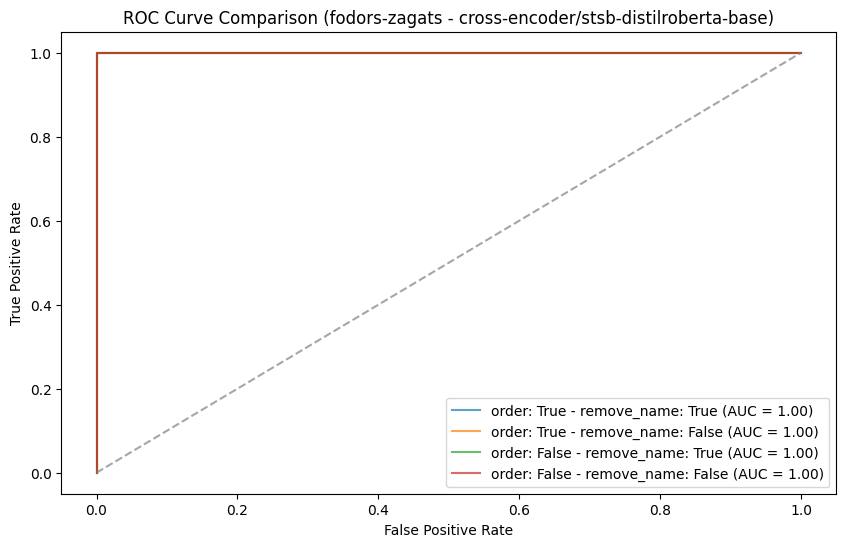

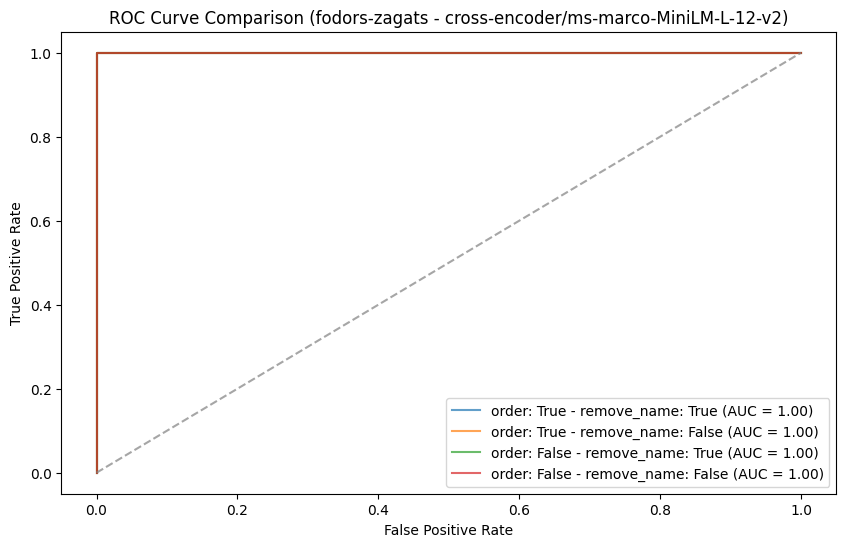

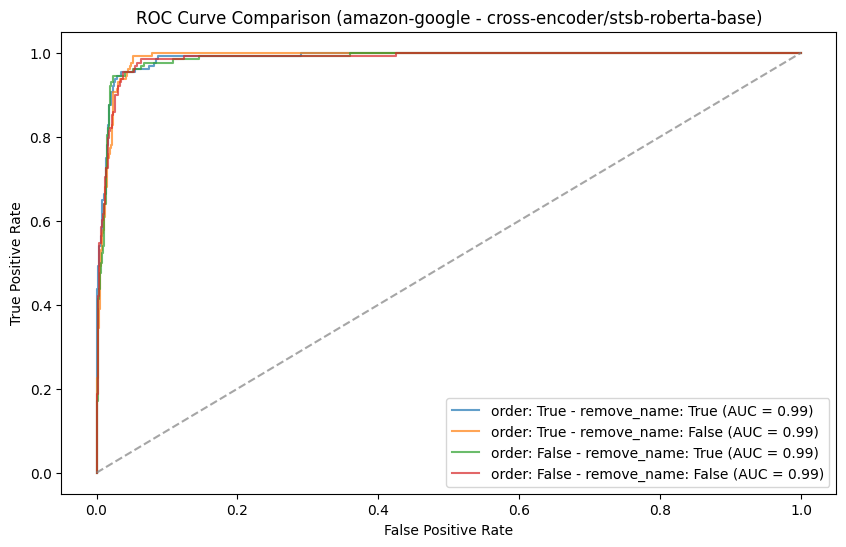

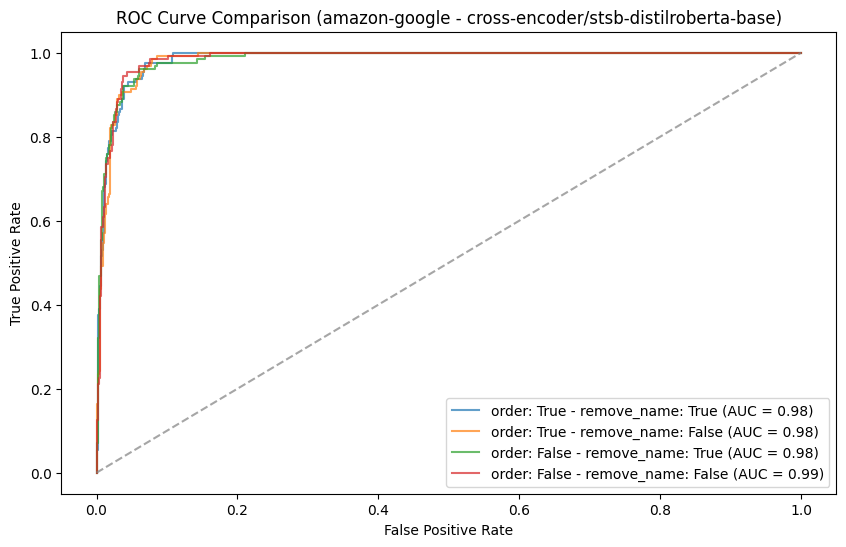

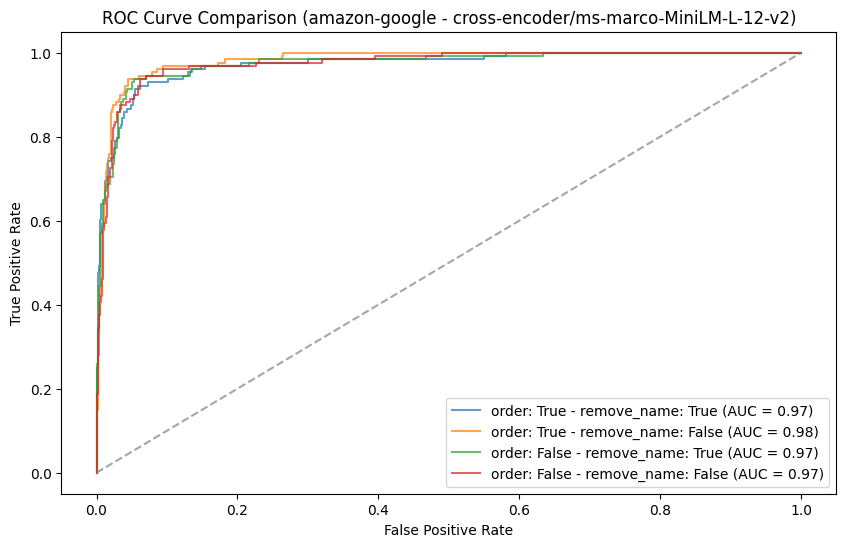

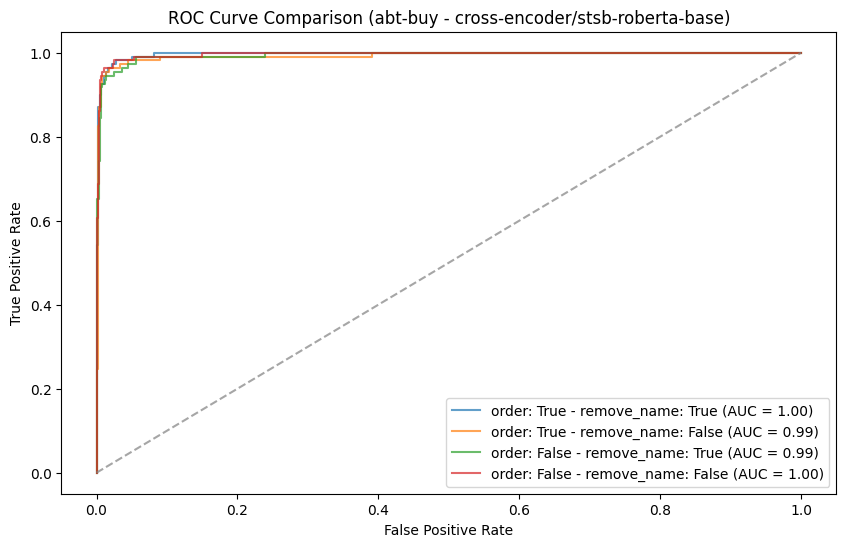

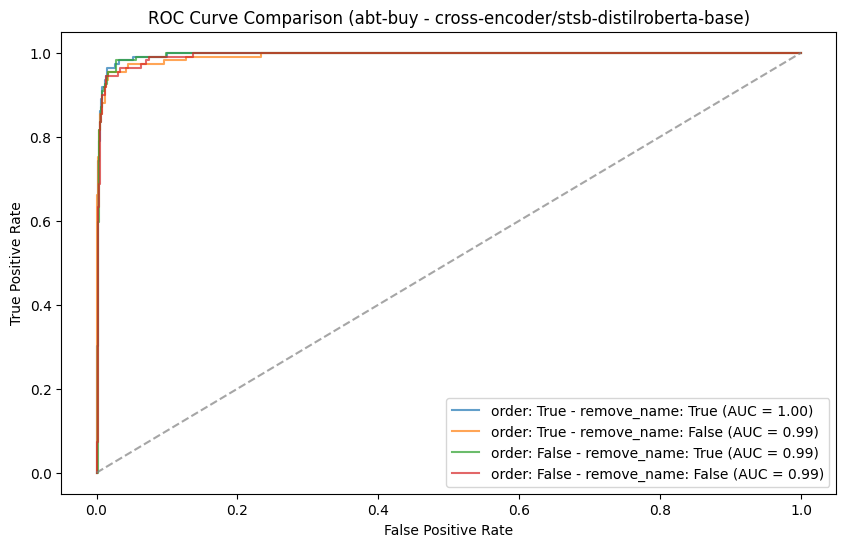

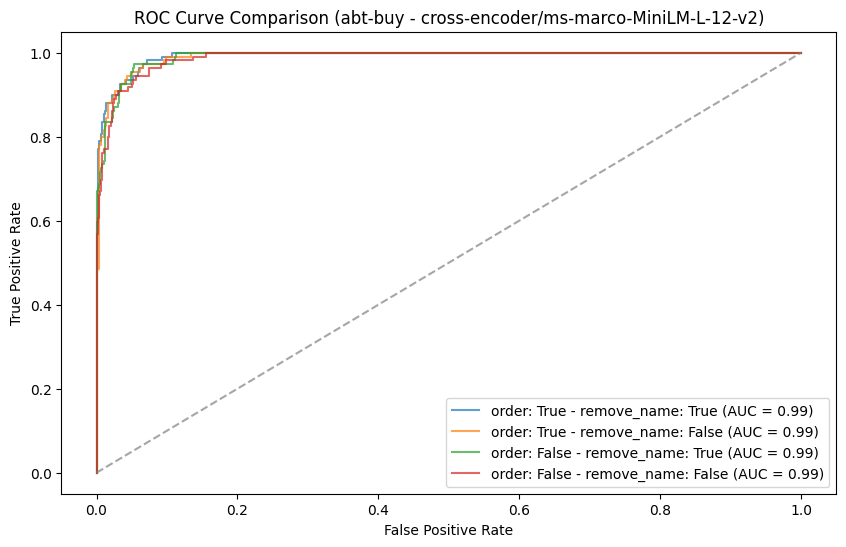

In [9]:
from sklearn.metrics import roc_curve, auc

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

plt.figure(figsize=(10, 6))

for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        plt.figure(figsize=(10, 6))
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                fpr, tpr, auc_score = metrics["roc_curve"]
                plt.plot(fpr, tpr, label=f"order: {order_cols} - remove_name: {remove_col_names} (AUC = {auc_score:.2f})", alpha=0.7)

        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve Comparison ({data_name} - {model_name})")
        plt.legend()
        plt.show()

### 4. Table of Metrics

In [10]:
import pandas as pd

all_results = []

for data_name, models in results_dict.items():
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                all_results.append([
                    data_name, model_name, order_cols, remove_col_names,
                    metrics["precision"], metrics["recall"], metrics["f1"],
                    metrics["roc_auc"], metrics["accuracy"], metrics["train_time"]
                ])

df_results = pd.DataFrame(all_results, columns=["Dataset", "Model", "Order Cols", "Remove Cols",
                                                 "Precision", "Recall", "F1", "ROC AUC", "Accuracy", "Train Time (in seconds)"])

df_results

Dataset                                  Model  Order Cols  \
0   fodors-zagats        cross-encoder/stsb-roberta-base        True   
1   fodors-zagats        cross-encoder/stsb-roberta-base        True   
2   fodors-zagats        cross-encoder/stsb-roberta-base       False   
3   fodors-zagats        cross-encoder/stsb-roberta-base       False   
4   fodors-zagats  cross-encoder/stsb-distilroberta-base        True   
5   fodors-zagats  cross-encoder/stsb-distilroberta-base        True   
6   fodors-zagats  cross-encoder/stsb-distilroberta-base       False   
7   fodors-zagats  cross-encoder/stsb-distilroberta-base       False   
8   fodors-zagats  cross-encoder/ms-marco-MiniLM-L-12-v2        True   
9   fodors-zagats  cross-encoder/ms-marco-MiniLM-L-12-v2        True   
10  fodors-zagats  cross-encoder/ms-marco-MiniLM-L-12-v2       False   
11  fodors-zagats  cross-encoder/ms-marco-MiniLM-L-12-v2       False   
12  amazon-google        cross-encoder/stsb-roberta-base        True   
13  amazon-google        cross-encoder/stsb-roberta-base        True   
14  amazon-google        cross-encoder/stsb-roberta-base       False   
15  amazon-google        cross-encoder/stsb-roberta-base       False   
16  amazon-google  cross-encoder/stsb-distilroberta-base        True   
17  amazon-google  cross-encoder/stsb-distilroberta-base        True   
18  amazon-google  cross-encoder/stsb-distilroberta-base       False   
19  amazon-google  cross-encoder/stsb-distilroberta-base       False   
20  amazon-google  cross-encoder/ms-marco-MiniLM-L-12-v2        True   
21  amazon-google  cross-encoder/ms-marco-MiniLM-L-12-v2        True   
22  amazon-google  cross-encoder/ms-marco-MiniLM-L-12-v2       False   
23  amazon-google  cross-encoder/ms-marco-MiniLM-L-12-v2       False   
24        abt-buy        cross-encoder/stsb-roberta-base        True   
25        abt-buy        cross-encoder/stsb-roberta-base        True   
26        abt-buy        cross-encoder/stsb-roberta-base       False   
27        abt-buy        cross-encoder/stsb-roberta-base       False   
28        abt-buy  cross-encoder/stsb-distilroberta-base        True   
29        abt-buy  cross-encoder/stsb-distilroberta-base        True   
30        abt-buy  cross-encoder/stsb-distilroberta-base       False   
31        abt-buy  cross-encoder/stsb-distilroberta-base       False   
32        abt-buy  cross-encoder/ms-marco-MiniLM-L-12-v2        True   
33        abt-buy  cross-encoder/ms-marco-MiniLM-L-12-v2        True   
34        abt-buy  cross-encoder/ms-marco-MiniLM-L-12-v2       False   
35        abt-buy  cross-encoder/ms-marco-MiniLM-L-12-v2       False   

    Remove Cols  Precision    Recall        F1   ROC AUC  Accuracy  \
0          True   1.000000  1.000000  1.000000  1.000000  1.000000   
1         False   1.000000  1.000000  1.000000  1.000000  1.000000   
2          True   1.000000  1.000000  1.000000  1.000000  1.000000   
3         False   1.000000  1.000000  1.000000  1.000000  1.000000   
4          True   1.000000  1.000000  1.000000  1.000000  1.000000   
5         False   1.000000  1.000000  1.000000  1.000000  1.000000   
6          True   1.000000  1.000000  1.000000  1.000000  1.000000   
7         False   1.000000  1.000000  1.000000  1.000000  1.000000   
8          True   0.916667  1.000000  0.956522  1.000000  0.984848   
9         False   1.000000  1.000000  1.000000  1.000000  1.000000   
10         True   0.916667  1.000000  0.956522  1.000000  0.984848   
11        False   0.687500  1.000000  0.814815  1.000000  0.924242   
12         True   0.885496  0.906250  0.895753  0.988016  0.967703   
13        False   0.872180  0.906250  0.888889  0.988171  0.965311   
14         True   0.893130  0.914062  0.903475  0.985821  0.970096   
15        False   0.845588  0.898438  0.871212  0.985401  0.959330   
16         True   0.802817  0.890625  0.844444  0.984574  0.949761   
17        False   0.844961  0.851562  0.848249  0.983735  0.953349   
18         True

### 5. Impact of the threshold on the metrics

Table A columns:
  column_name              data_example
1        addr  '435 s. la cienega blv.'
2        city             'los angeles'
3       phone              310/246-1501
4        type                  american 

Table B columns:
  column_name           data_example
1        addr  '10801 w. pico blvd.'
2        city              'west la'
3       phone           310-475-3585
4        type               american 

Serialized entities 



/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


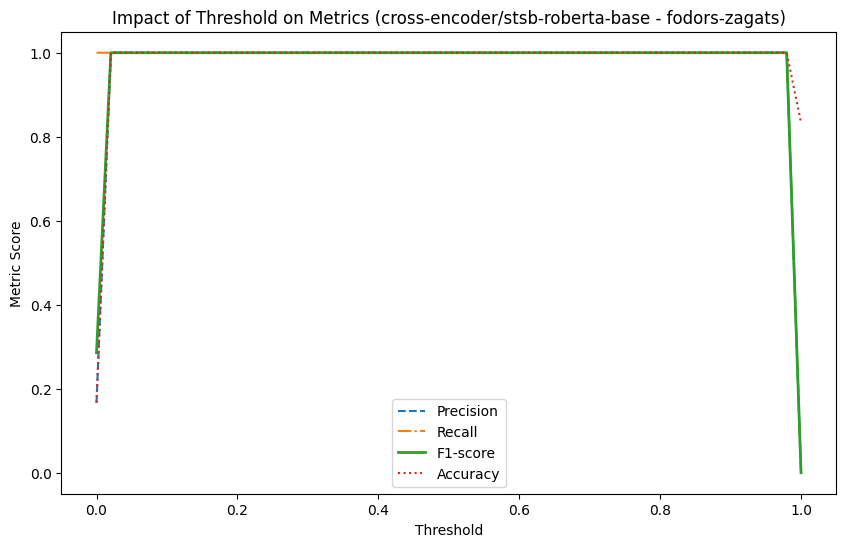

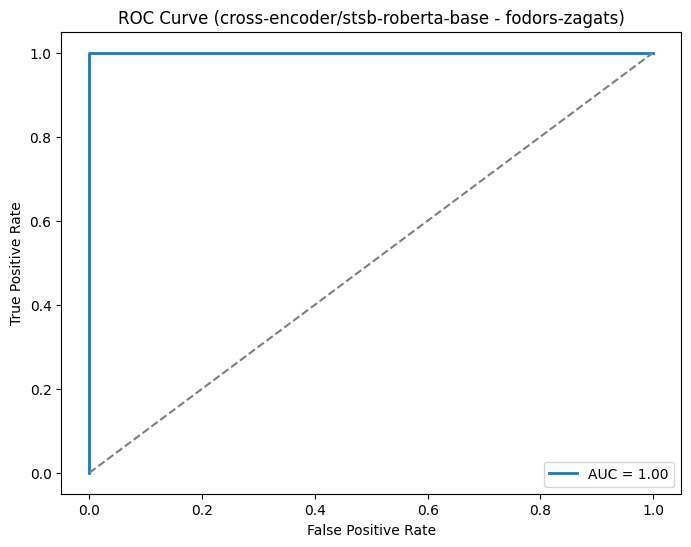

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


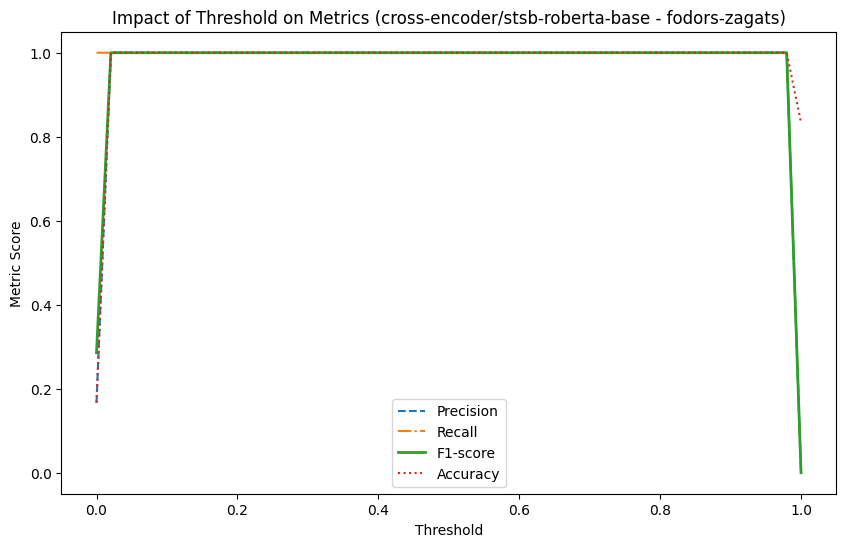

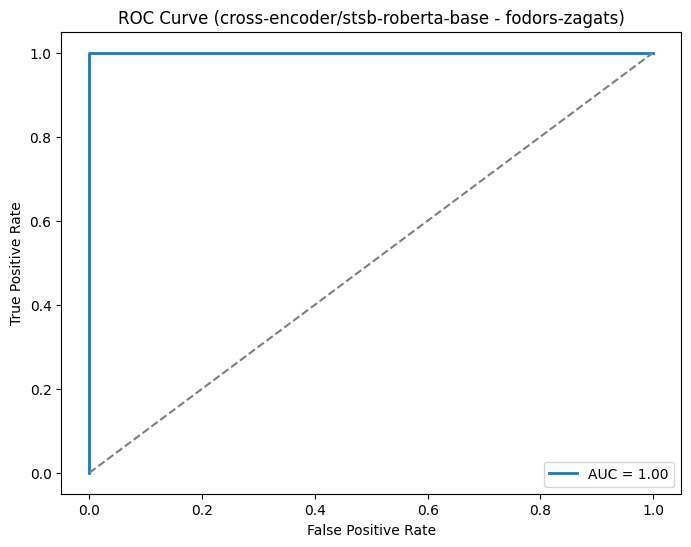

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


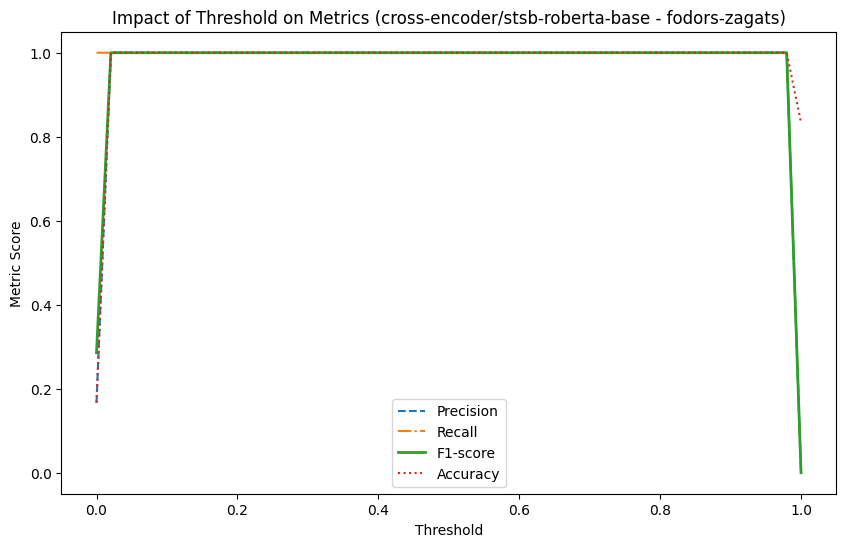

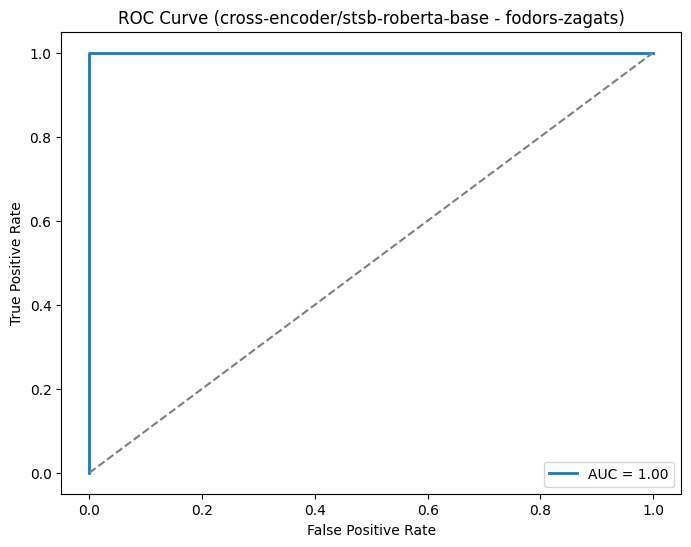

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


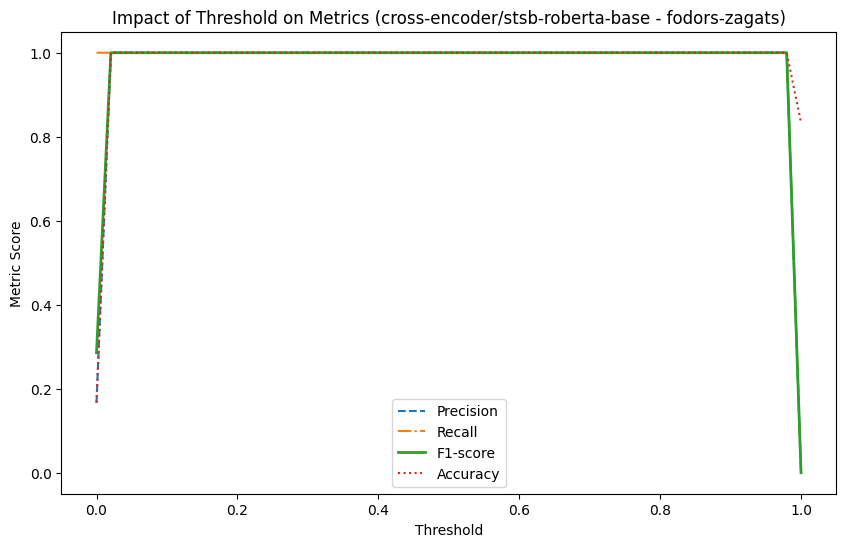

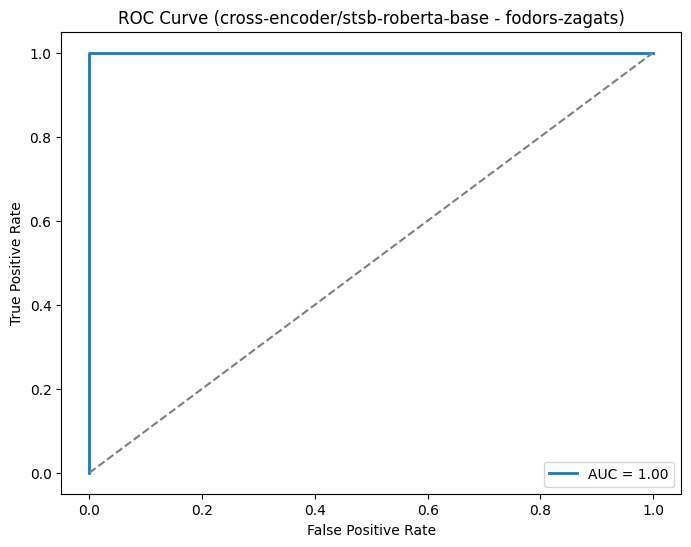

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


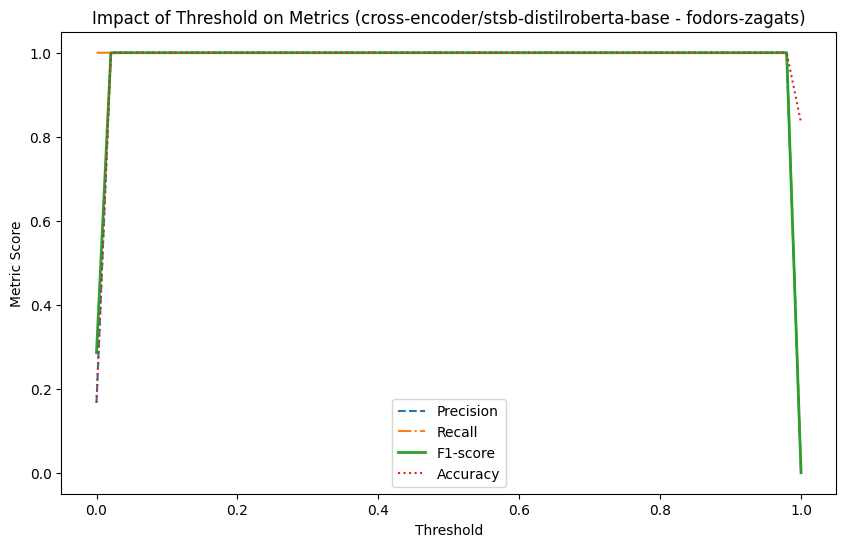

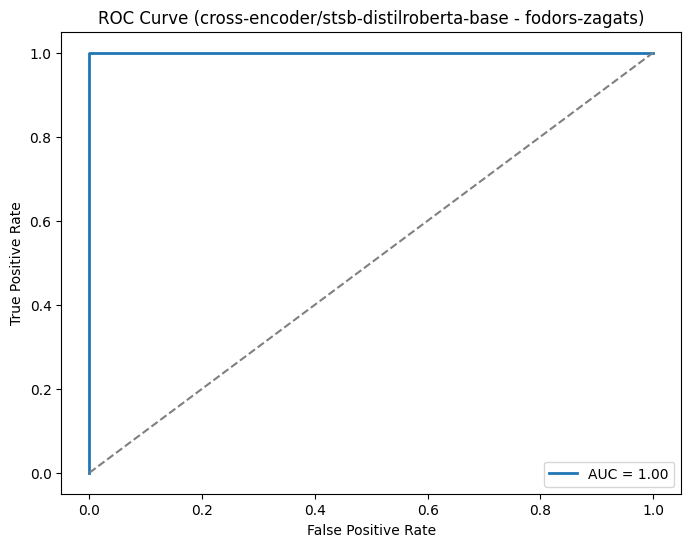

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


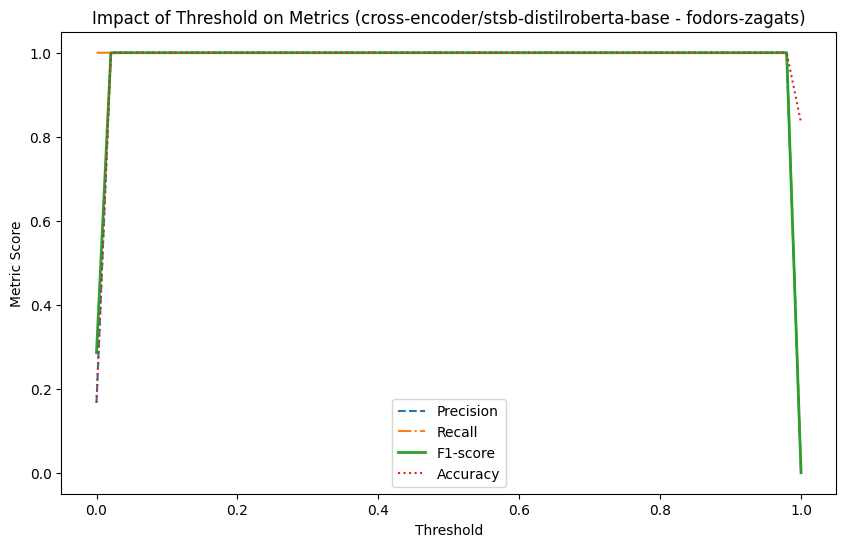

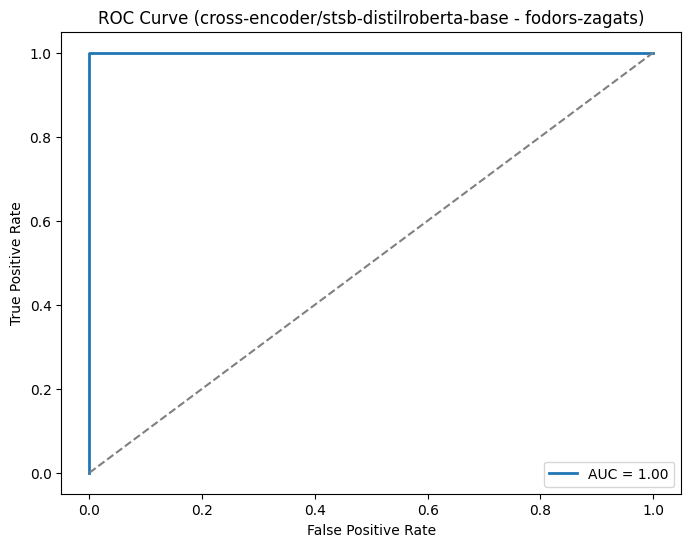

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


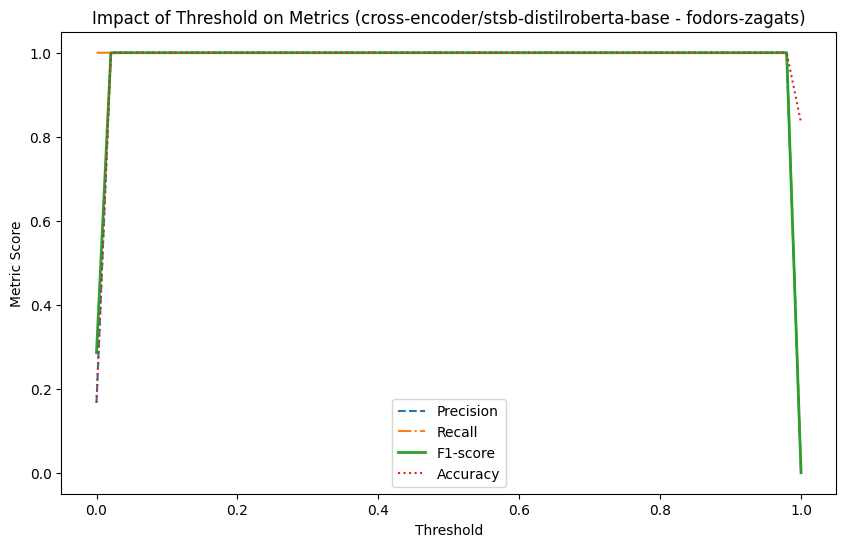

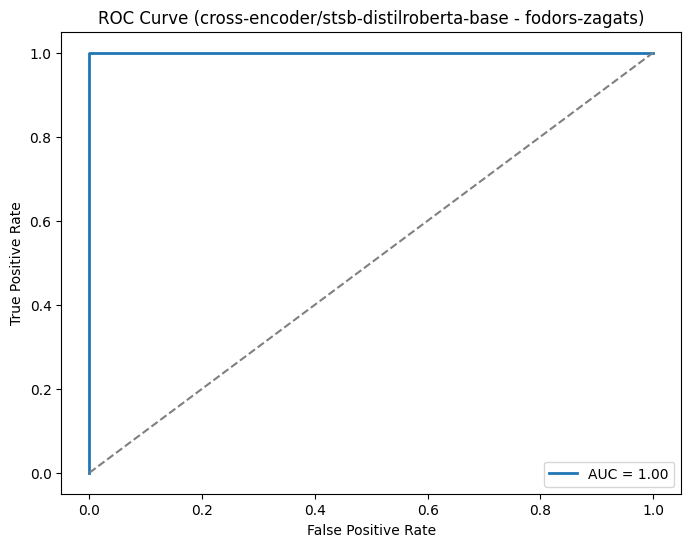

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


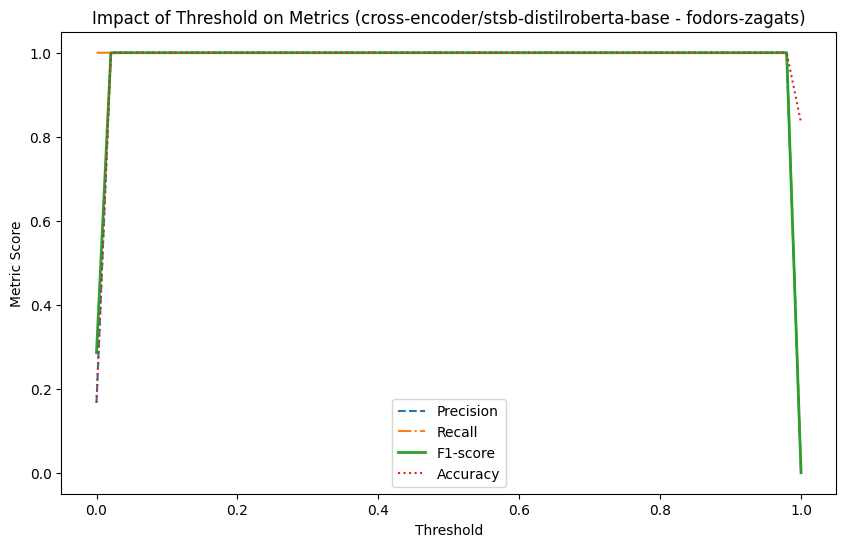

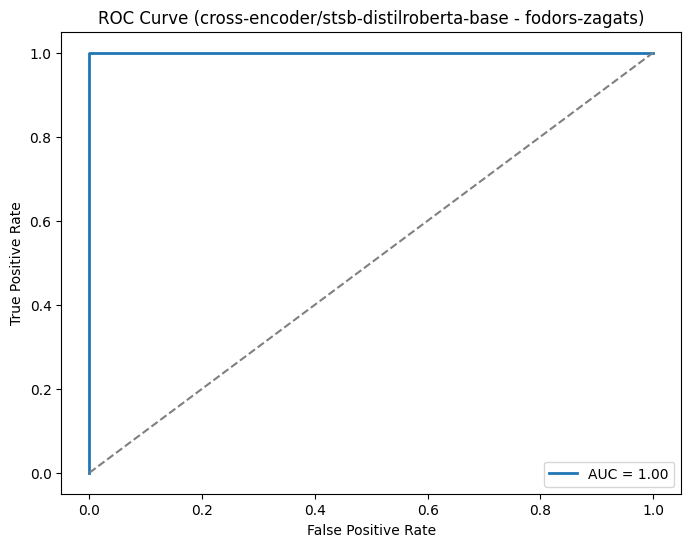

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


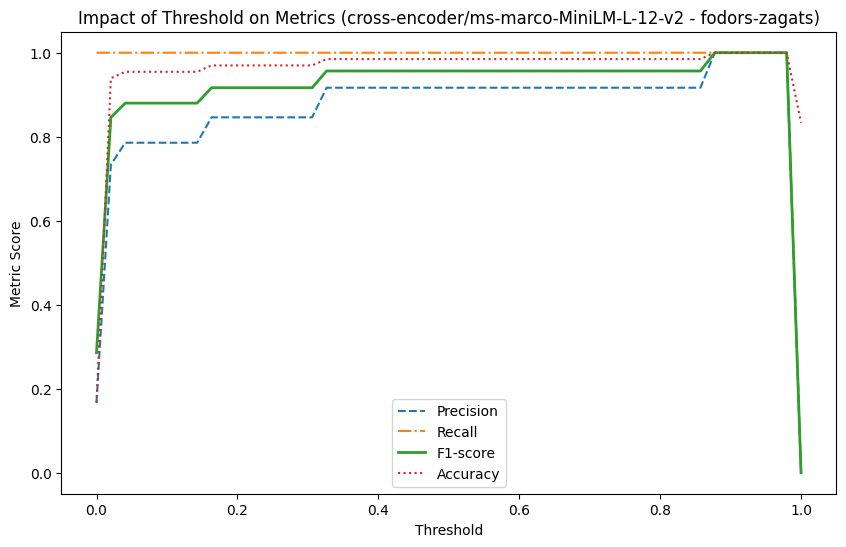

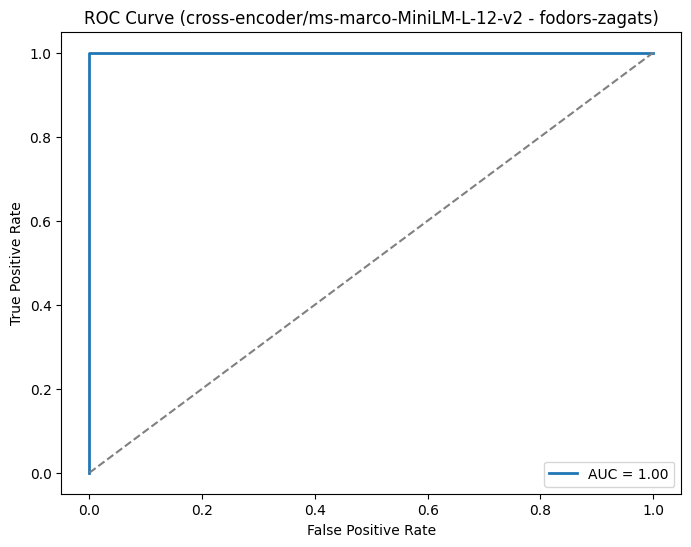

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


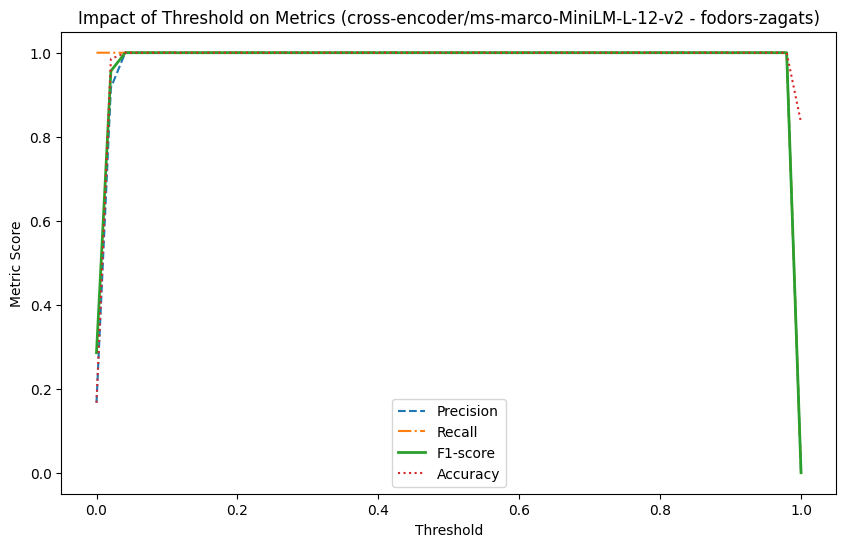

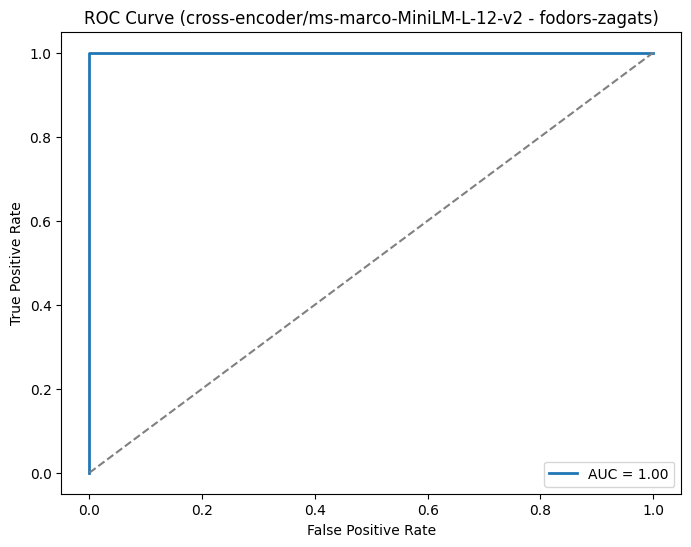

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


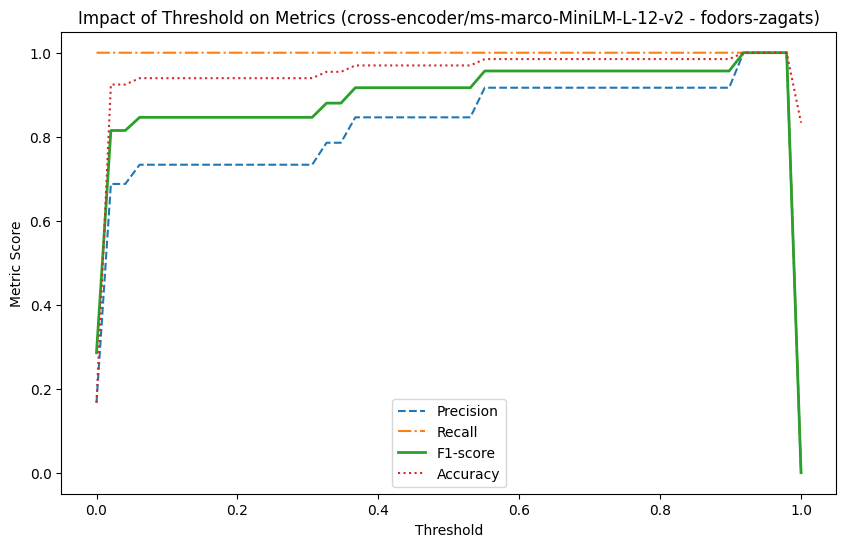

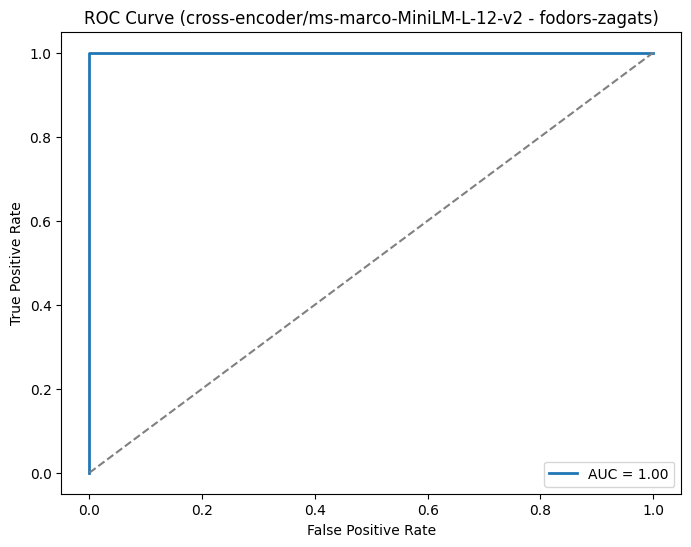

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


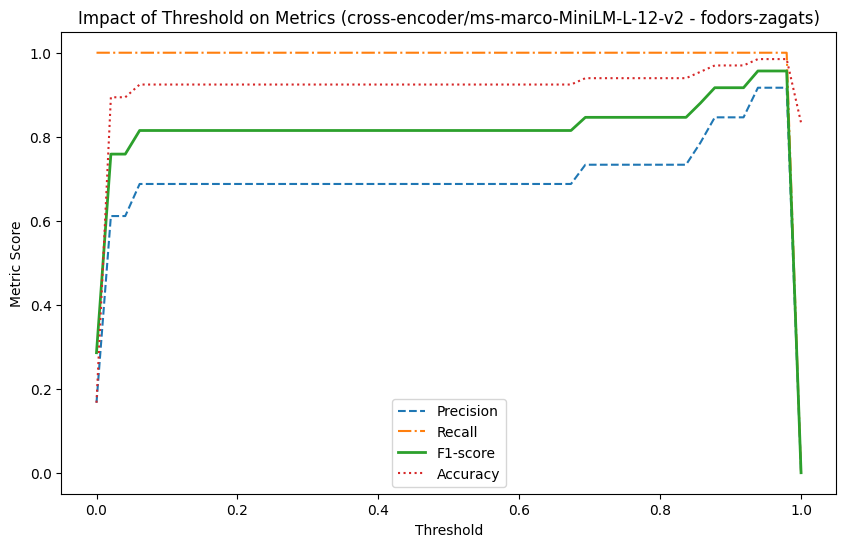

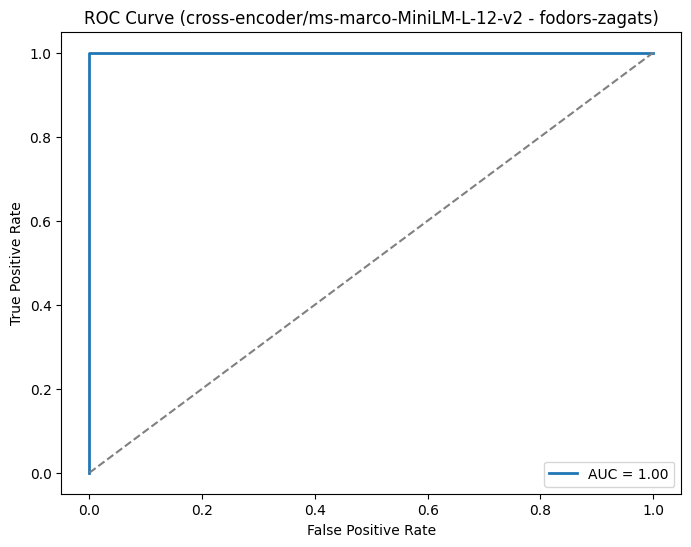

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Serialized entities 



/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


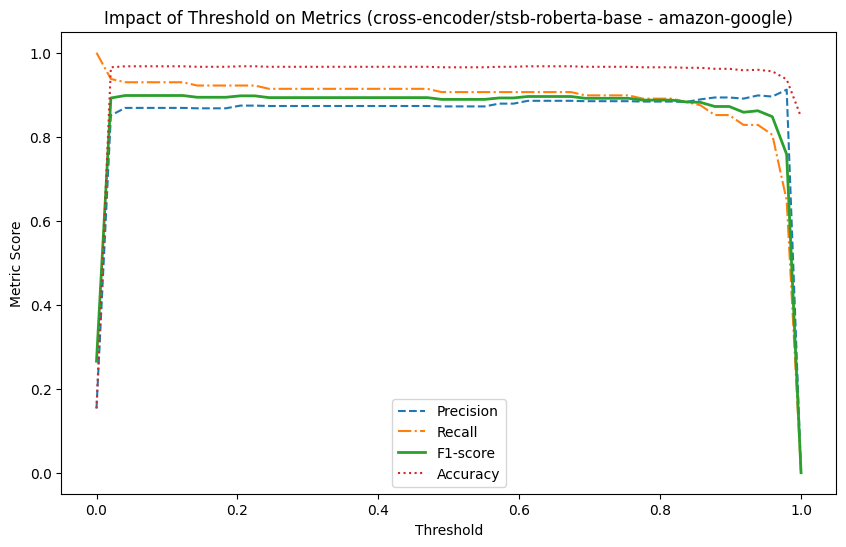

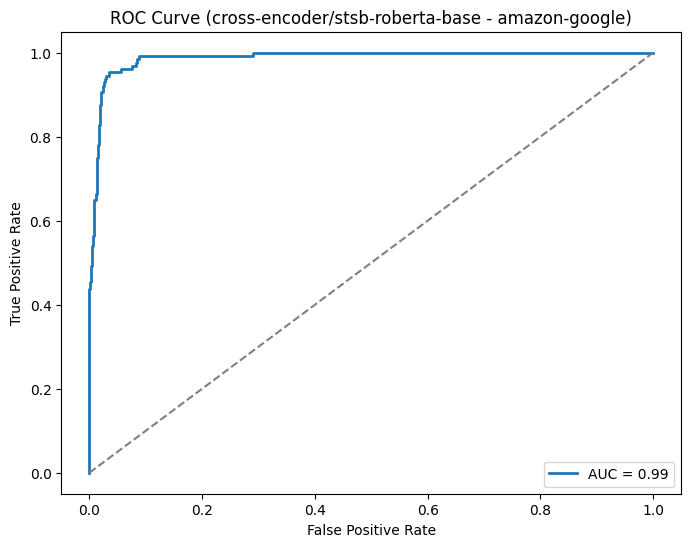

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


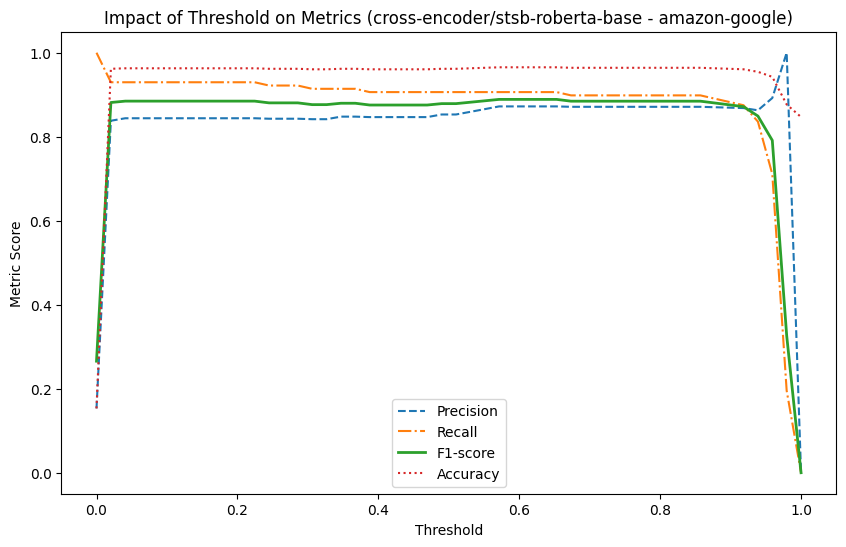

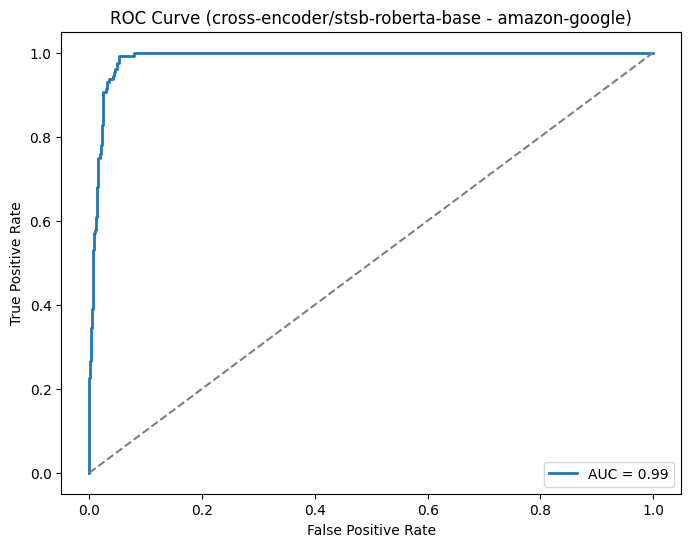

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


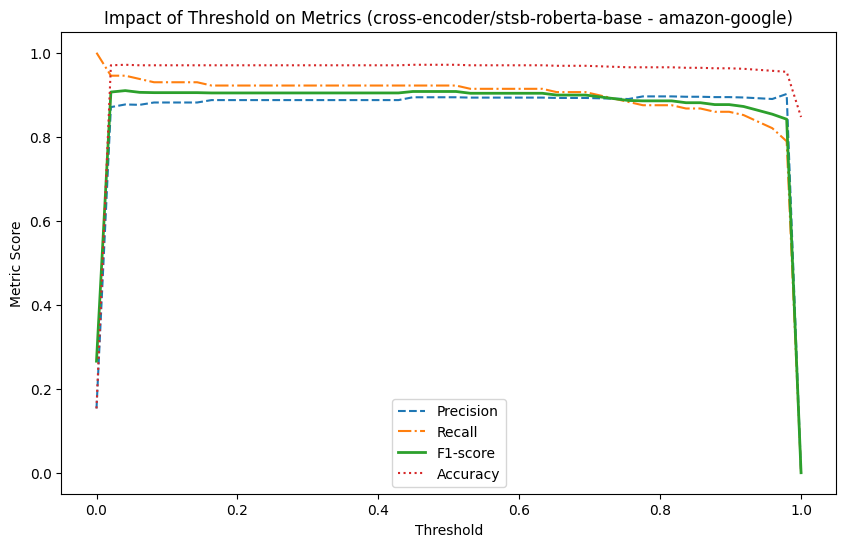

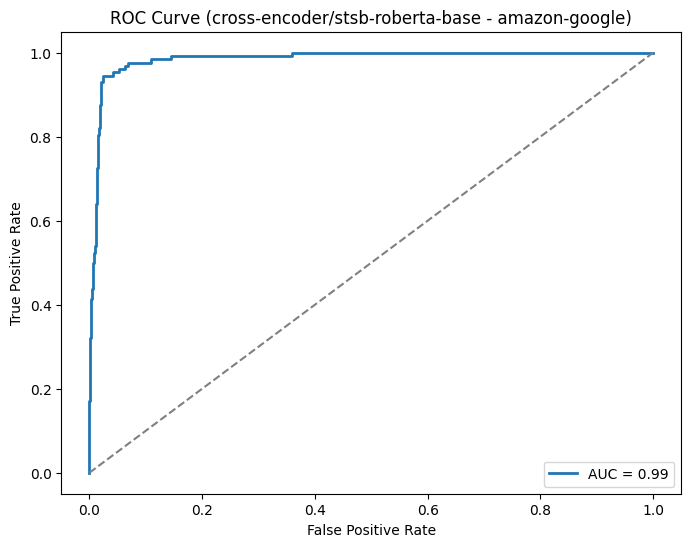

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


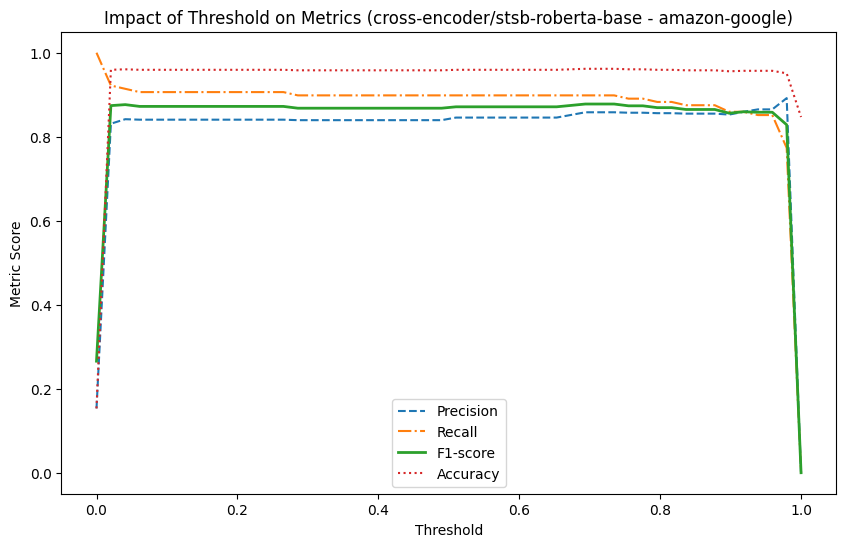

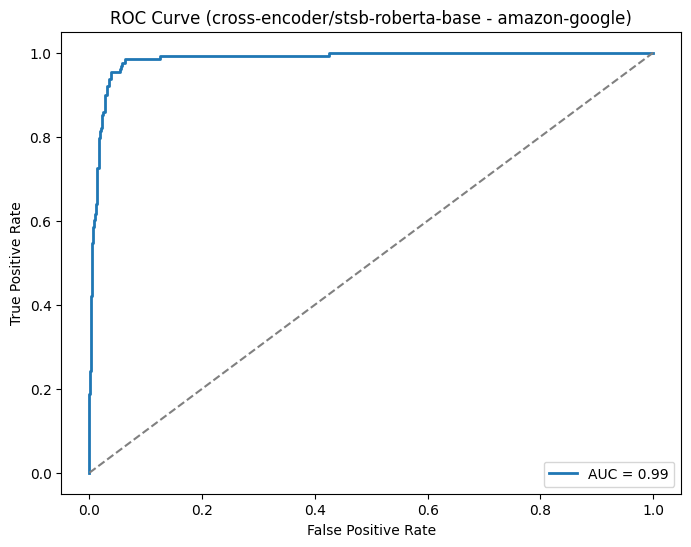

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


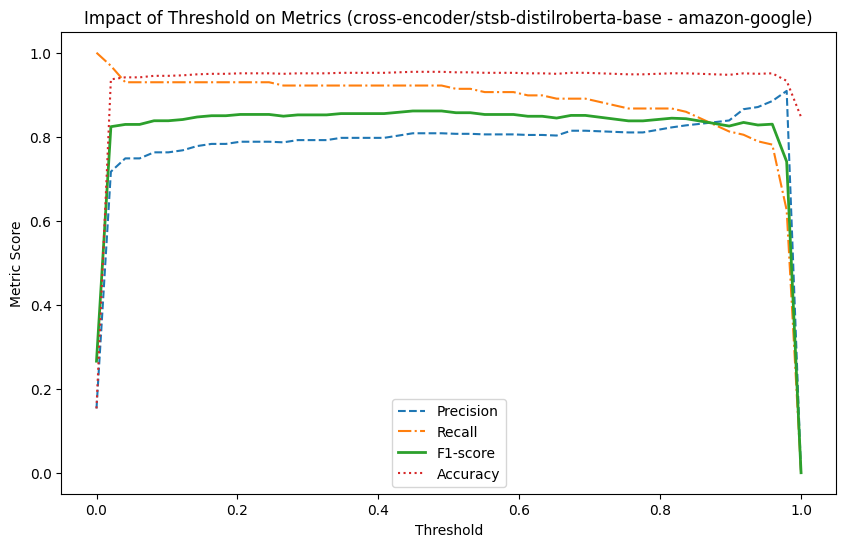

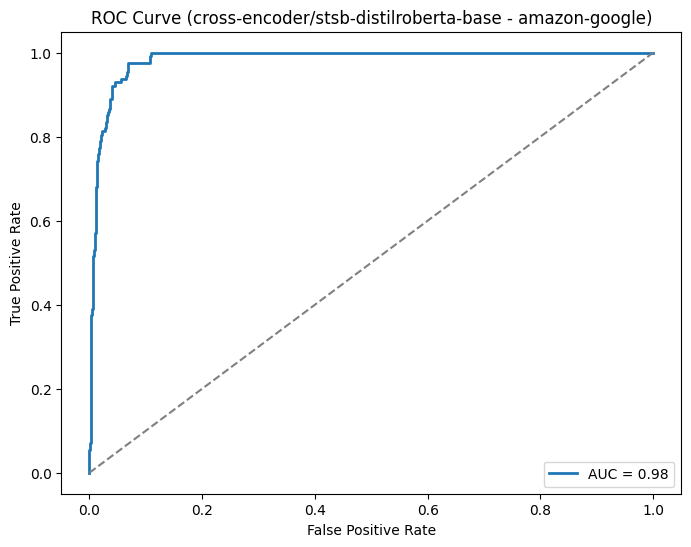

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


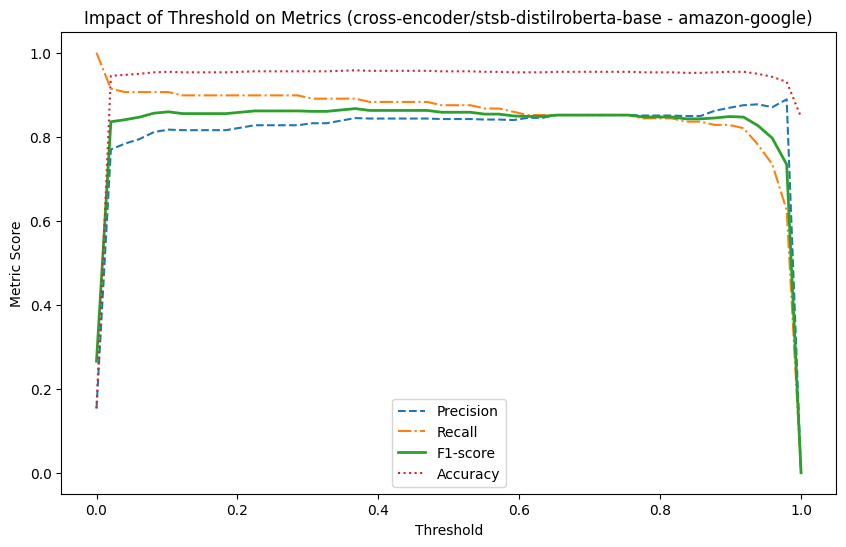

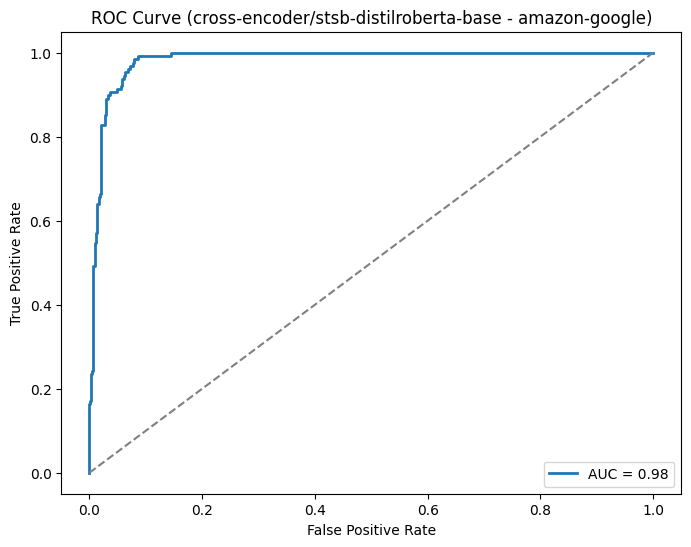

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


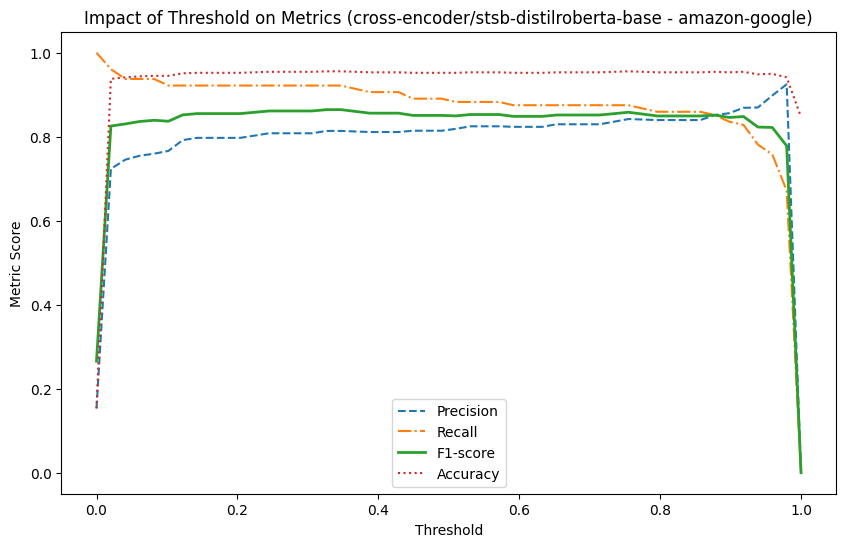

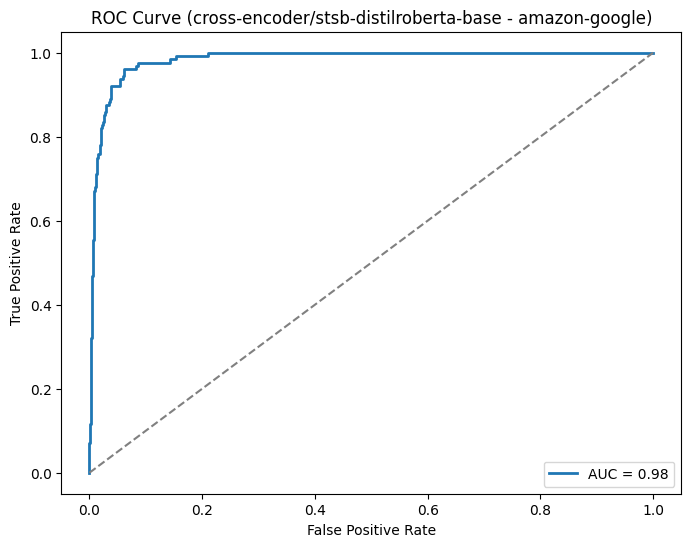

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


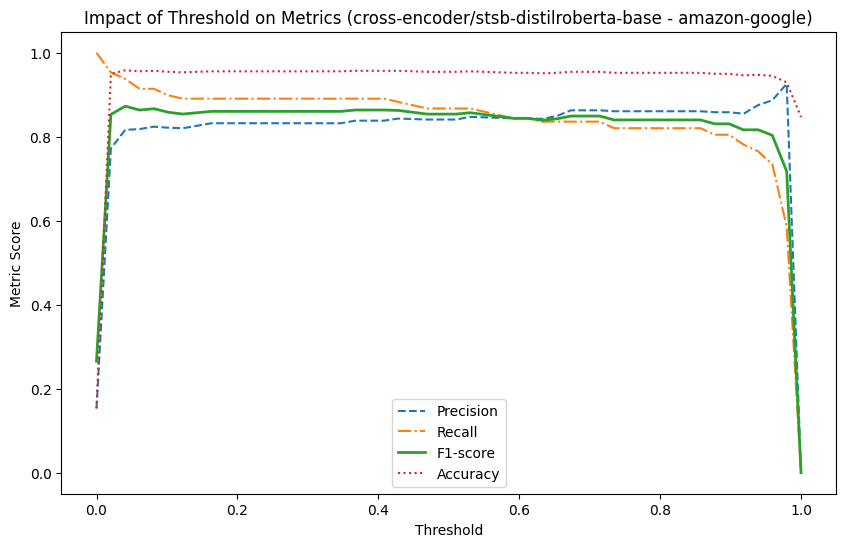

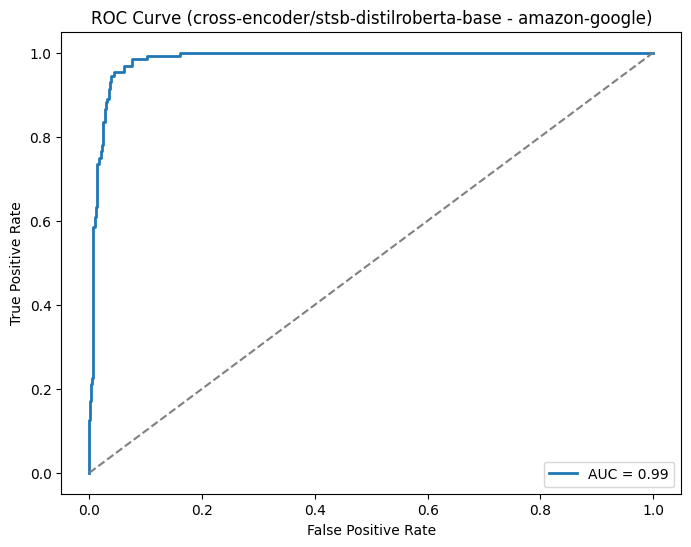

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


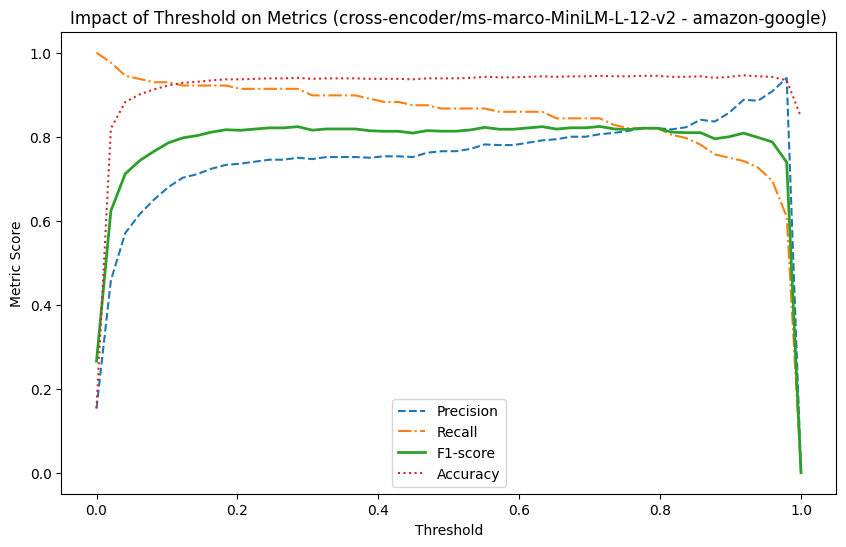

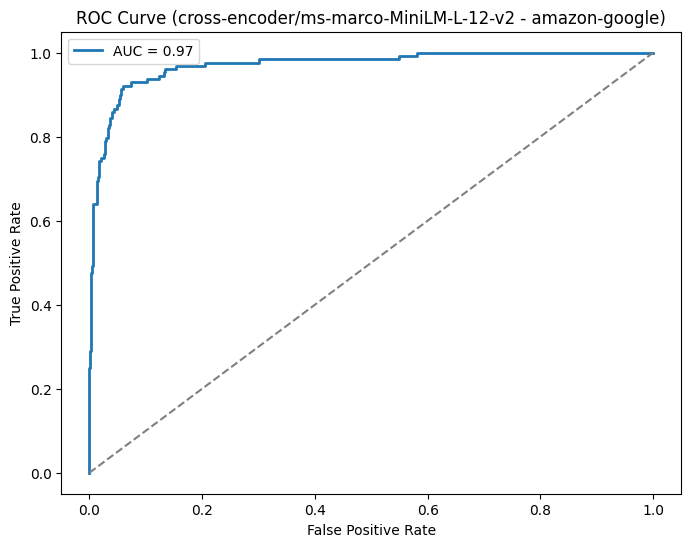

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


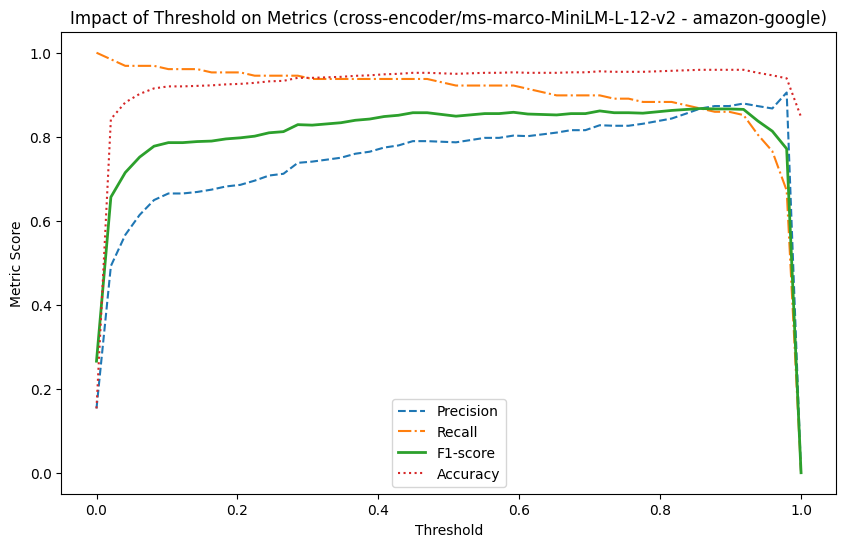

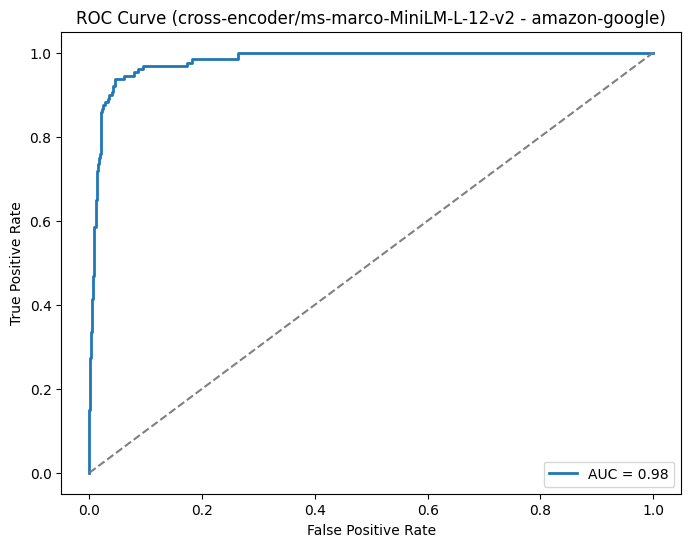

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


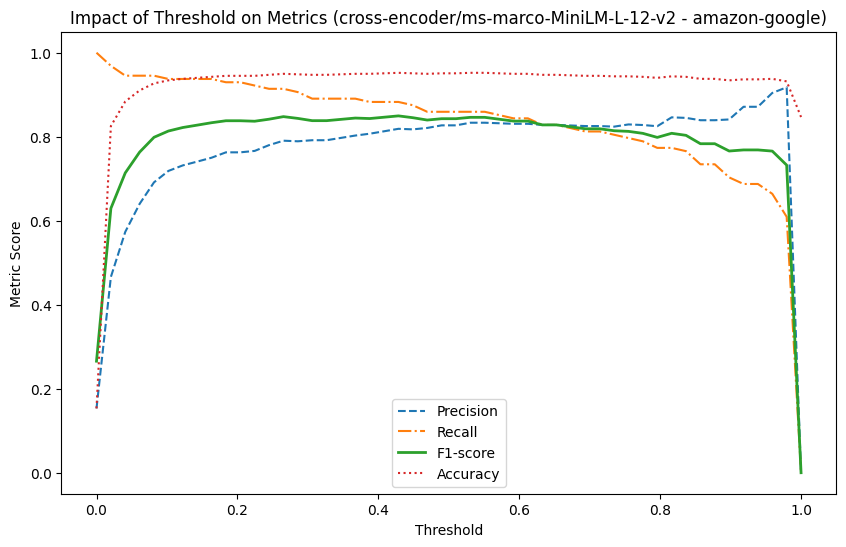

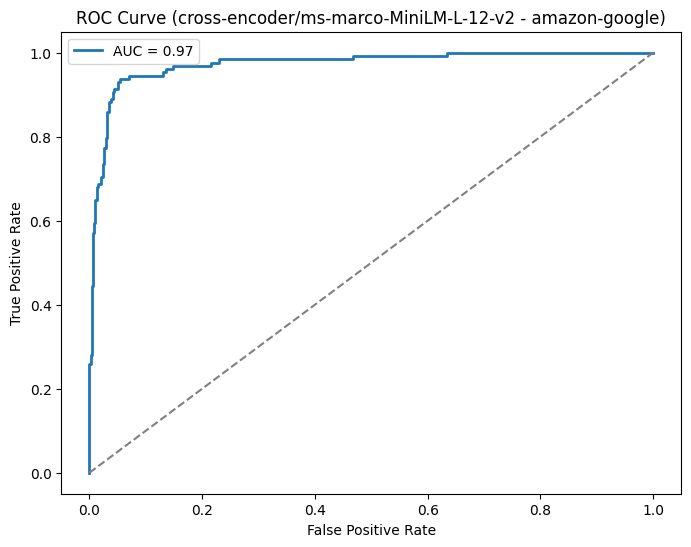

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


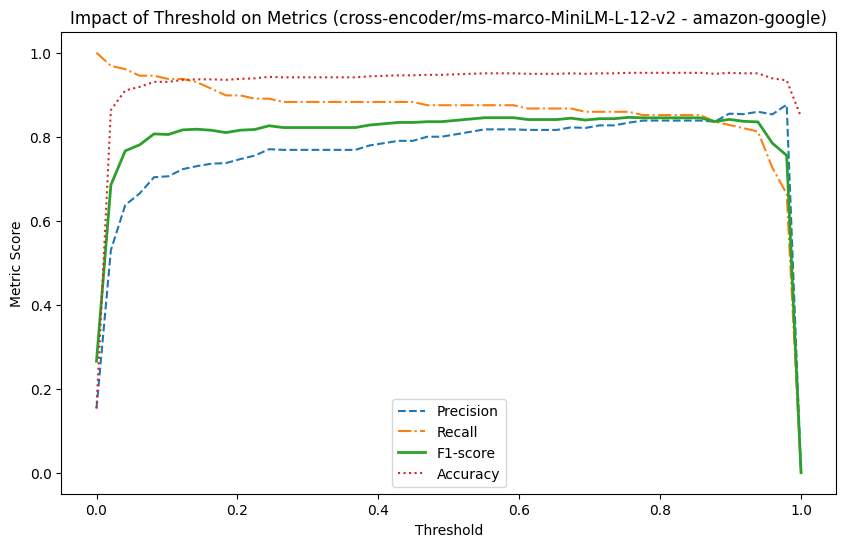

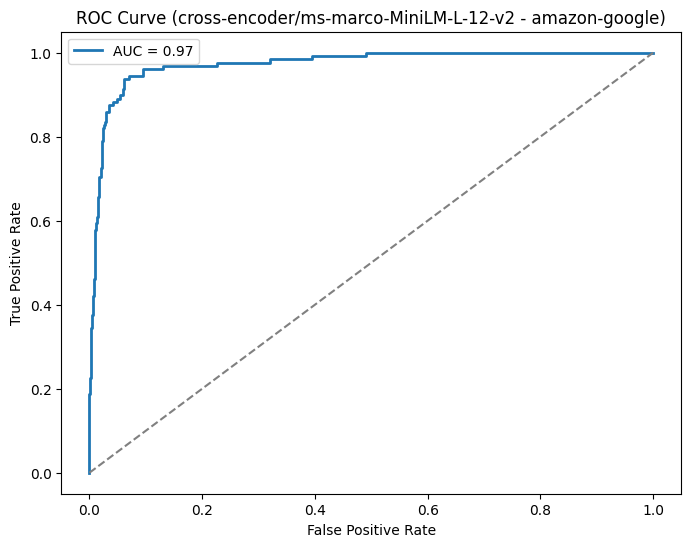

Table A columns:
   column_name                                       data_example
1  description  Sony Turntable - PSLX350H/ Belt Drive System/ ...
2        price                                                NaN 

Table B columns:
    column_name                                       data_example
1   description  Linksys EtherFast 8-Port 10/100 Switch (New/Wo...
2  manufacturer                                            LINKSYS
3         price                                                NaN 

Columns are not the same in both tables
Table A columns: ['name' 'description' 'price']
Table B columns: ['name' 'description' 'manufacturer' 'price']
Serialized entities 



/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


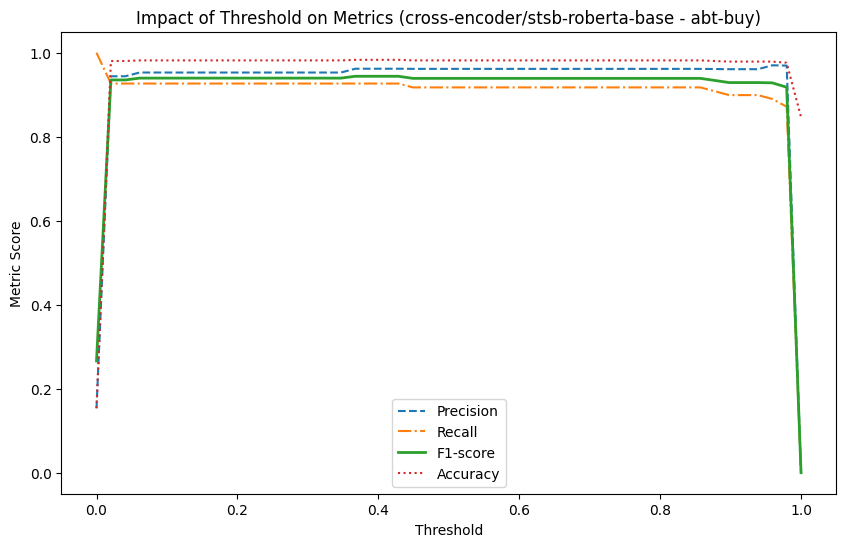

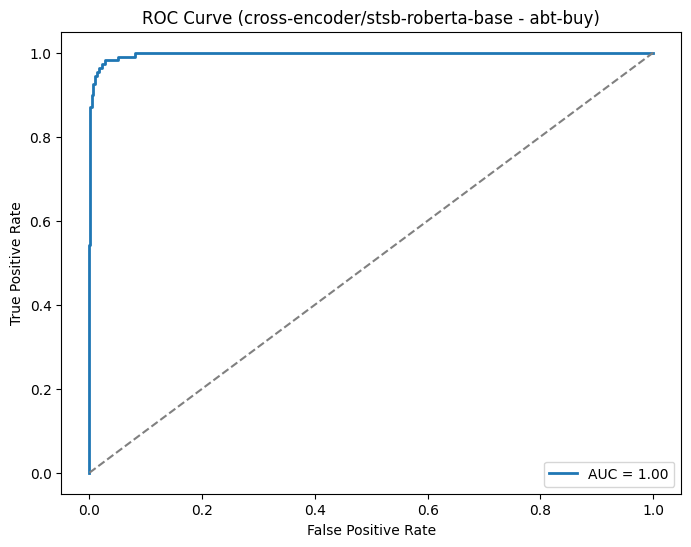

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


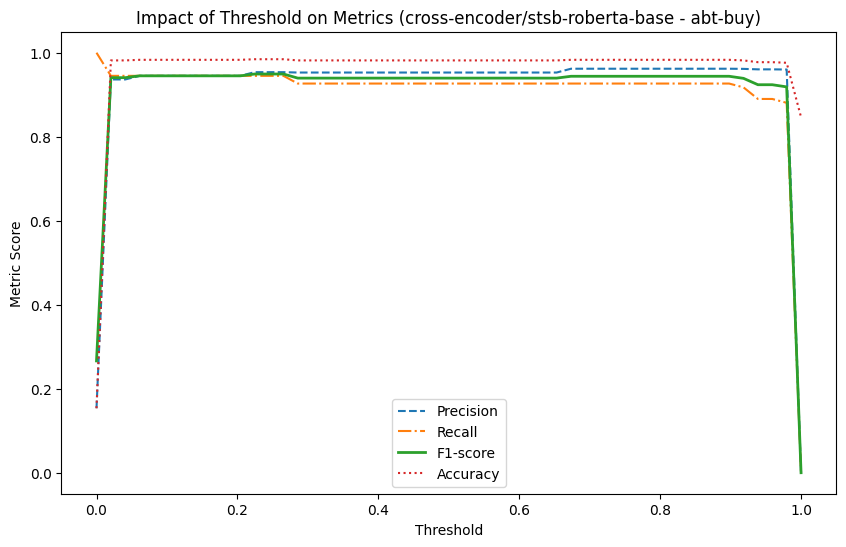

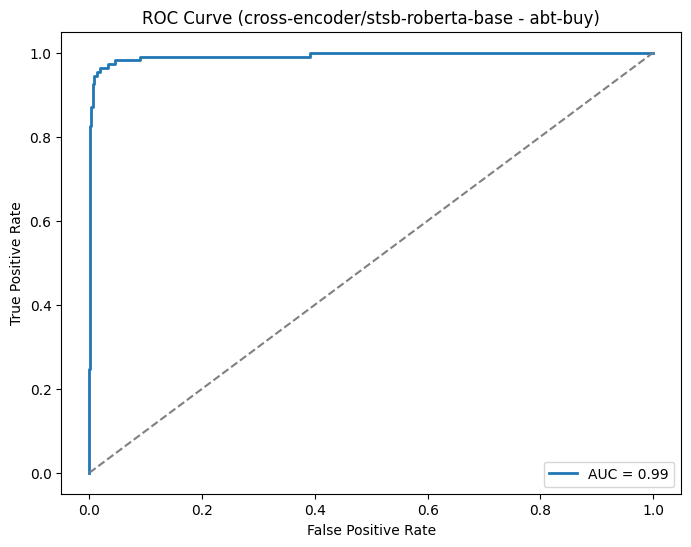

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


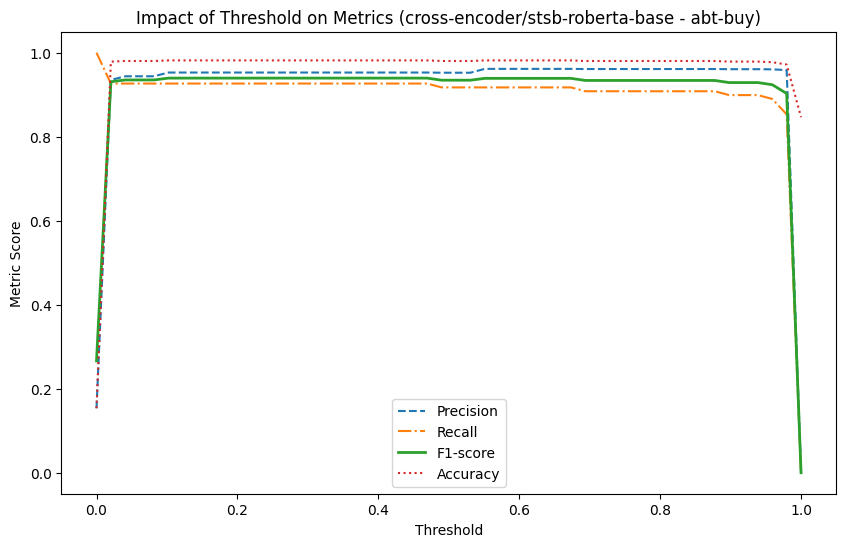

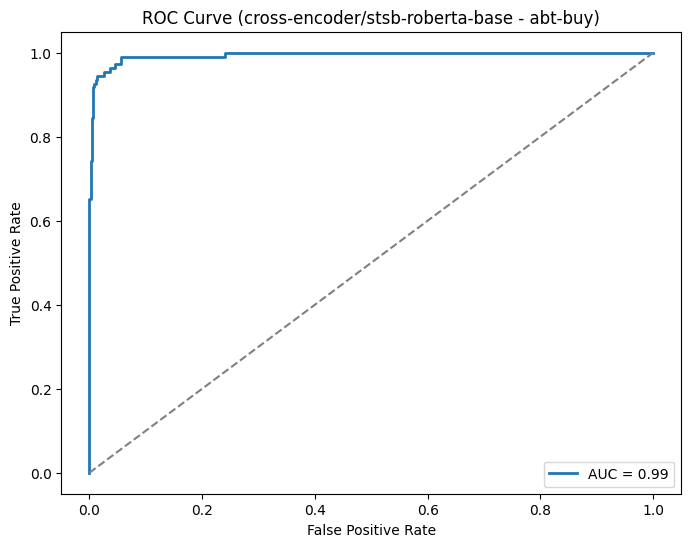

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


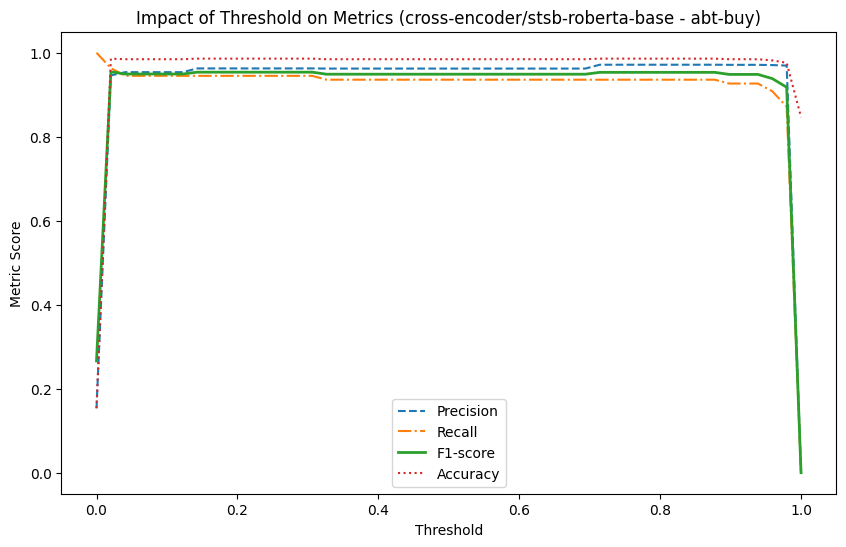

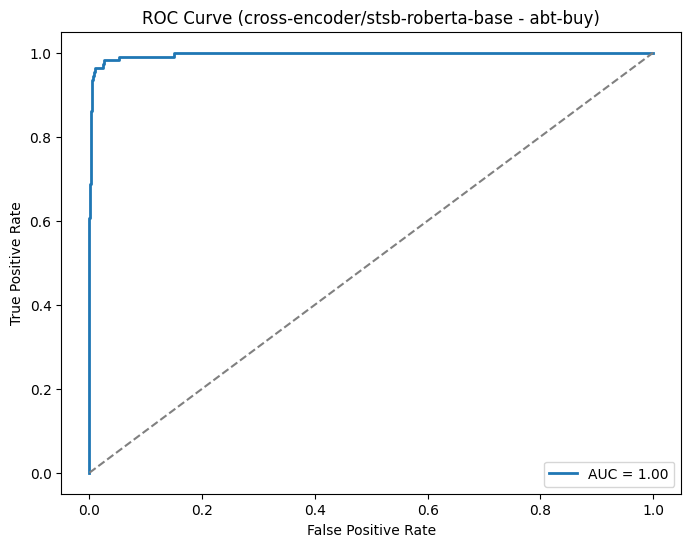

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


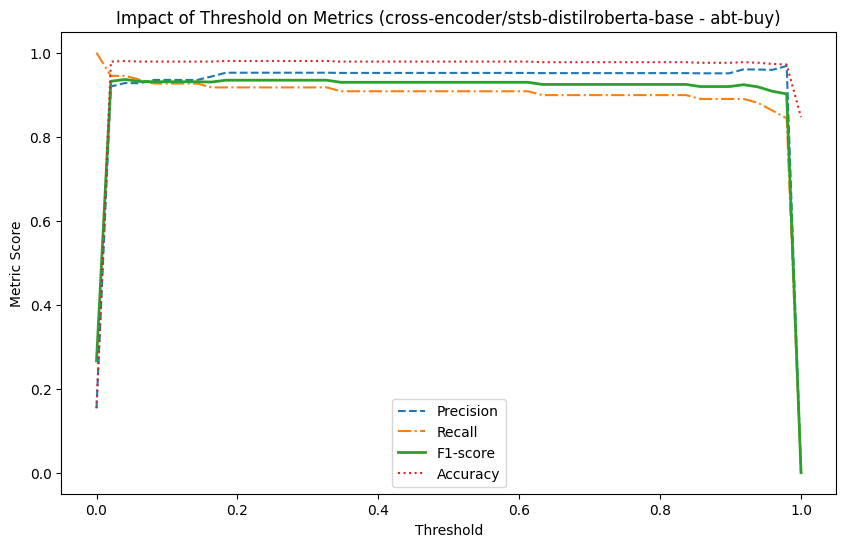

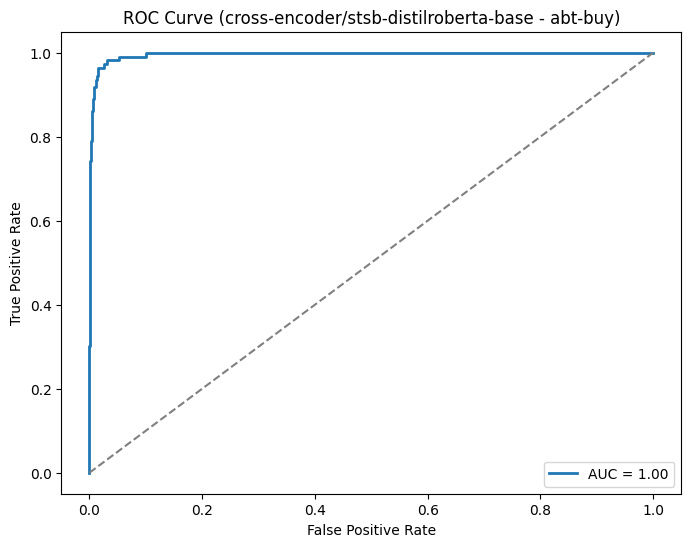

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


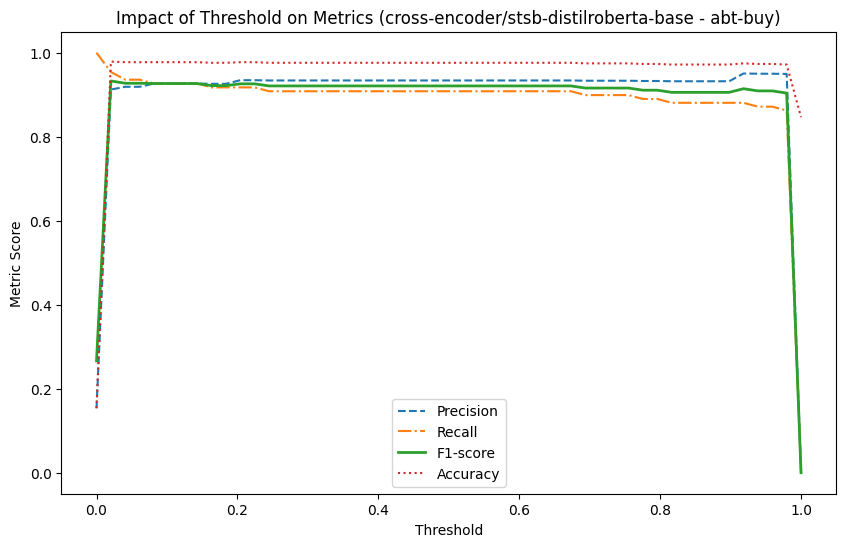

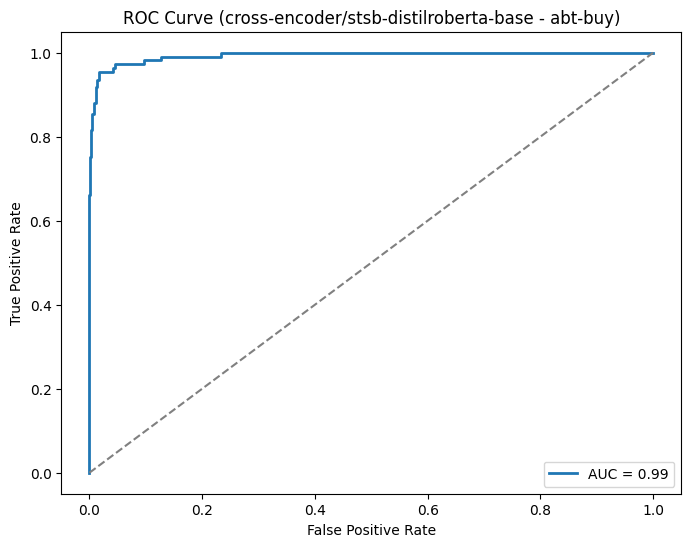

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


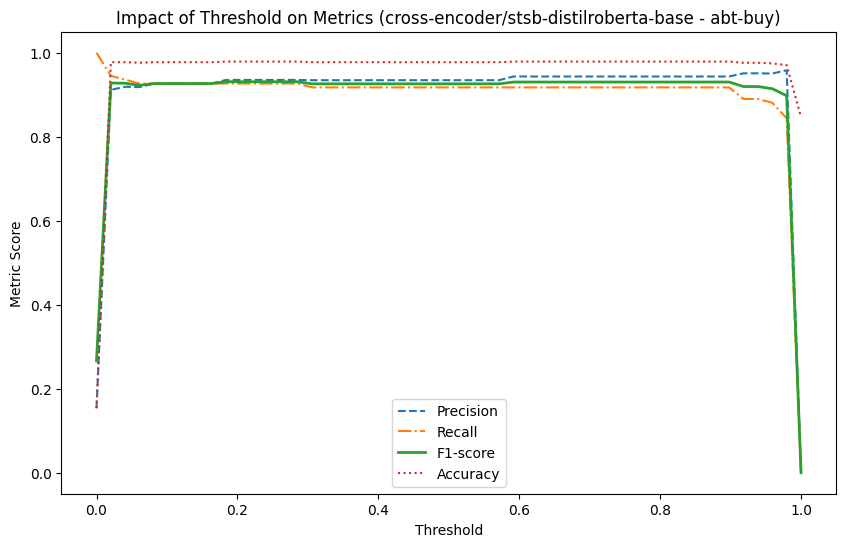

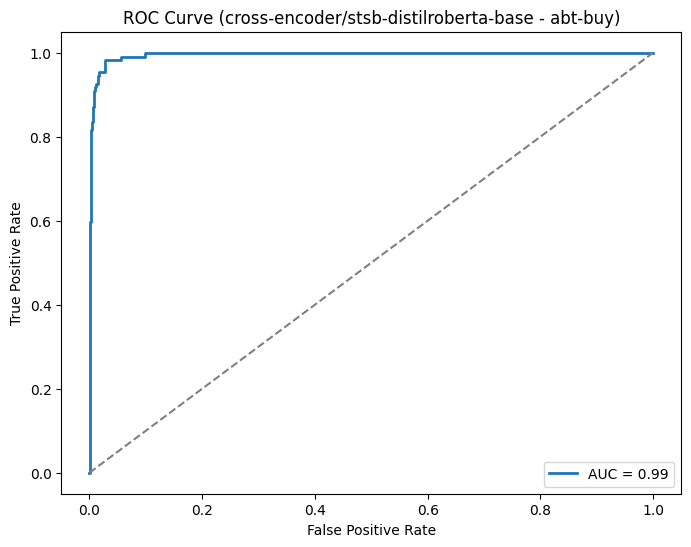

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


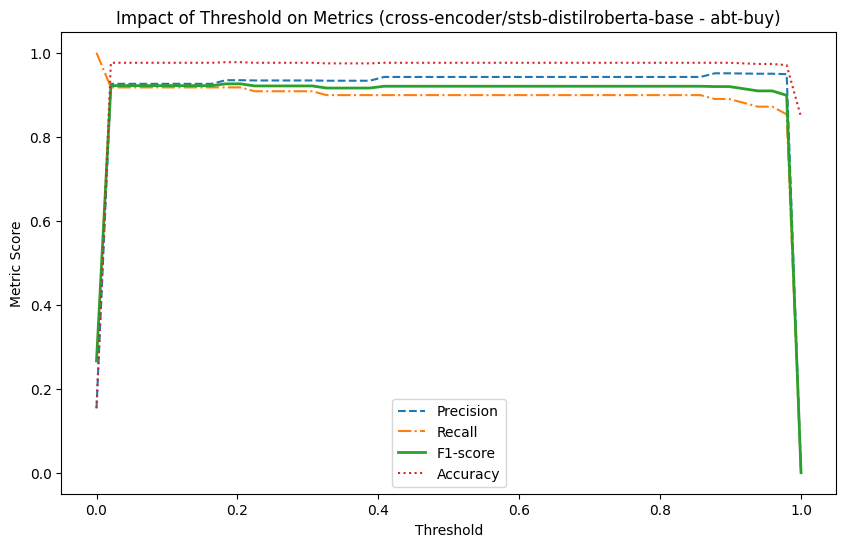

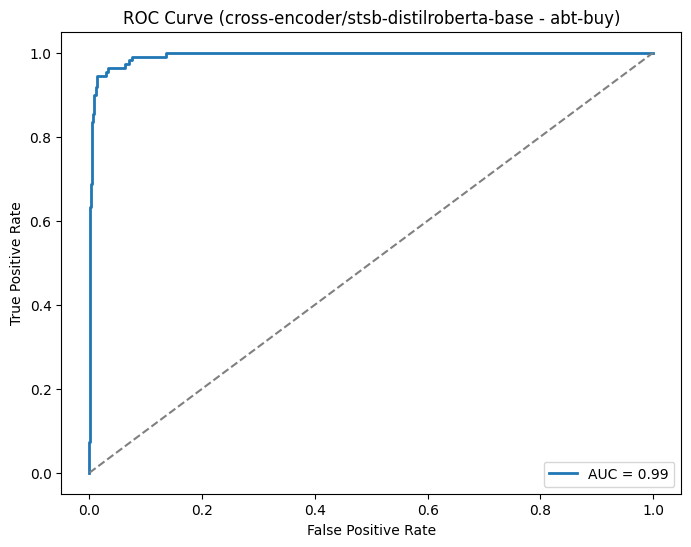

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


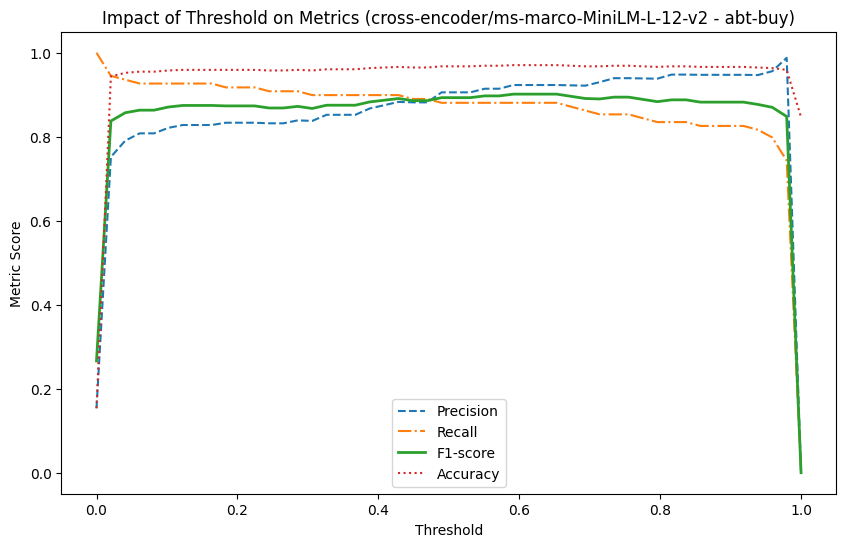

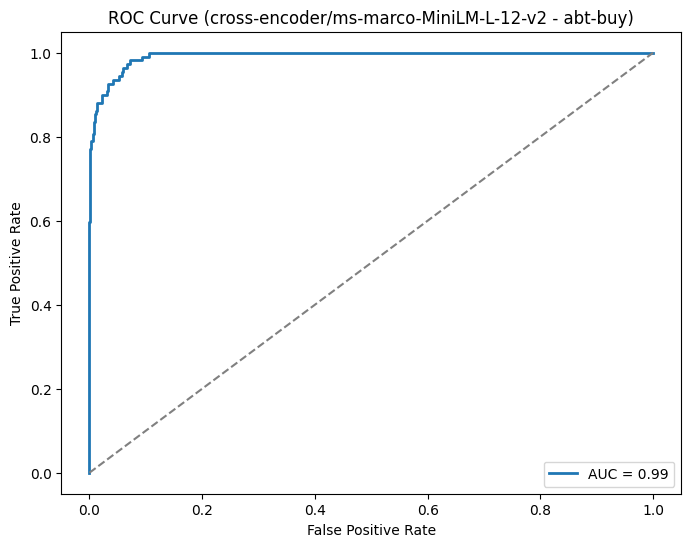

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


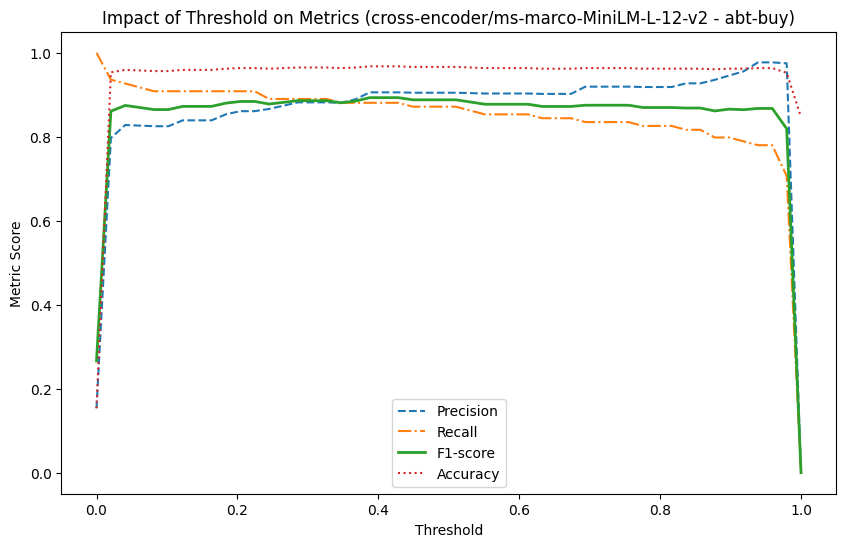

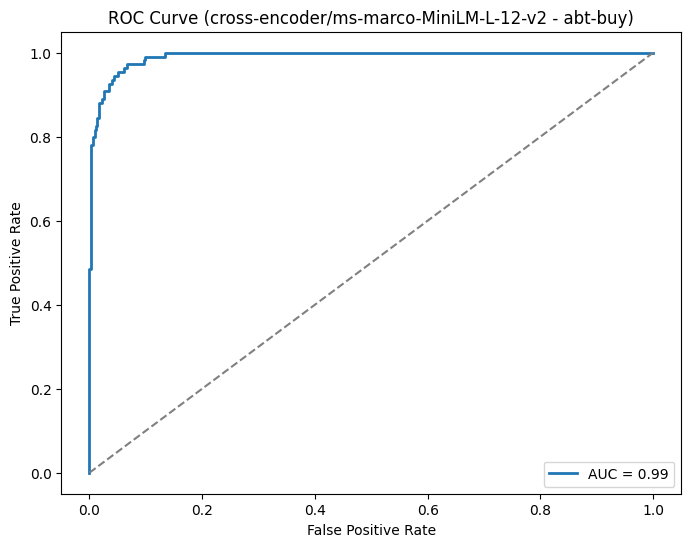

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


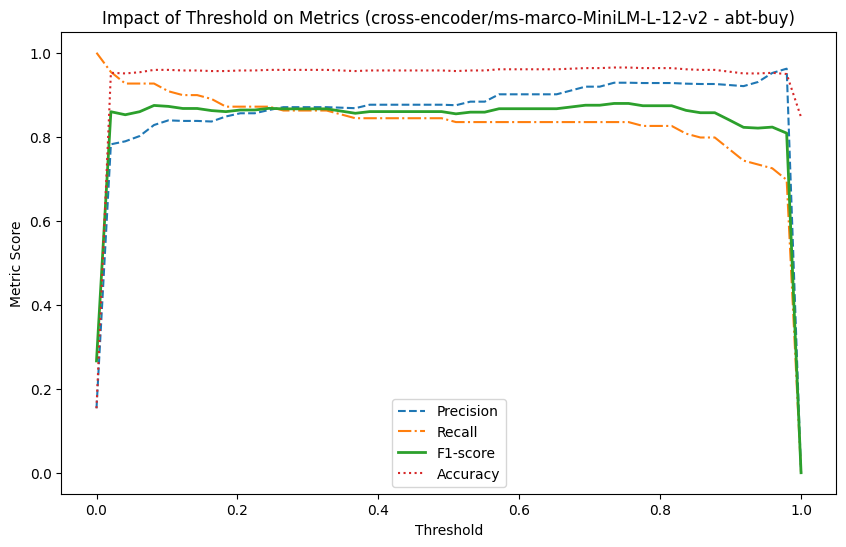

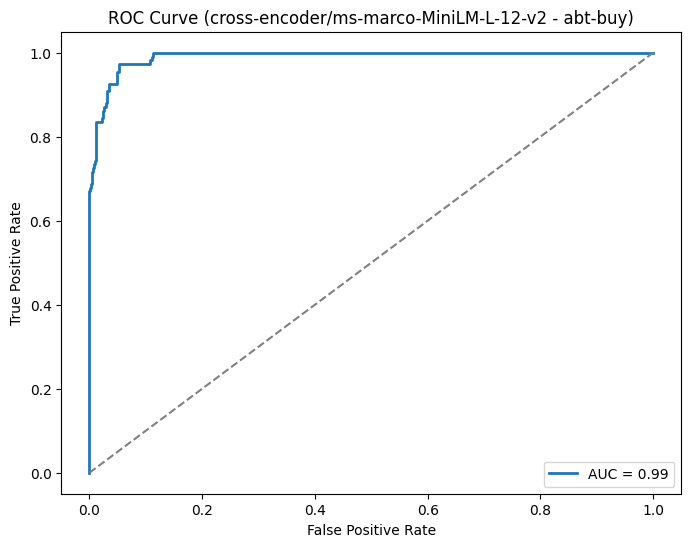

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


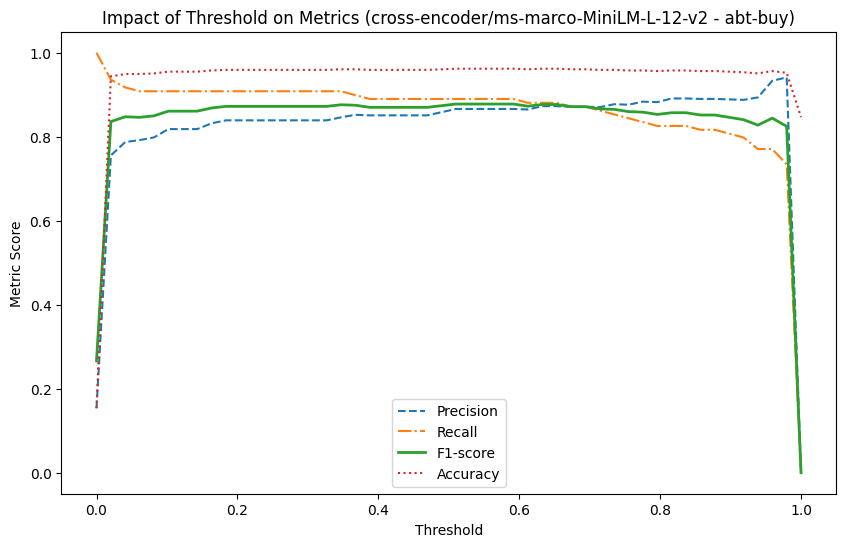

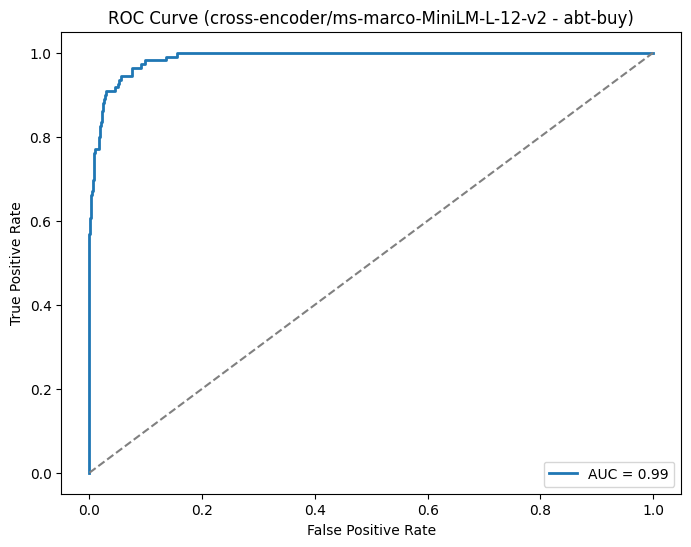

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc

# Store results for plotting
thresholds = np.linspace(0, 1, 50)  # 50 different thresholds from 0 to 1

metrics_results = {}

# Loop through models and datasets
for data_name, models in results_dict.items():
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    for model_name, orders in models.items():
        for order_cols, removes in orders.items():
            for remove_col_names, metrics in removes.items():
                y_probs = np.array(metrics["logits"]["pred"])

                precisions, recalls, f1s, accuracies = [], [], [], []

                for thresh in thresholds:
                    y_pred = (y_probs >= thresh).astype(int)

                    precisions.append(precision_score(y_test, y_pred))
                    recalls.append(recall_score(y_test, y_pred))
                    f1s.append(f1_score(y_test, y_pred))
                    accuracies.append(accuracy_score(y_test, y_pred))

                # Plot results
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.plot(thresholds, precisions, label="Precision", linestyle="--")
                ax.plot(thresholds, recalls, label="Recall", linestyle="-.")
                ax.plot(thresholds, f1s, label="F1-score", linewidth=2)
                ax.plot(thresholds, accuracies, label="Accuracy", linestyle="dotted")

                ax.set_xlabel("Threshold")
                ax.set_ylabel("Metric Score")
                ax.set_title(f"Impact of Threshold on Metrics ({model_name} - {data_name})")
                ax.legend()
                plt.show()

                # ROC Curve
                fpr, tpr, _ = roc_curve(y_test, y_probs)
                auc_score = auc(fpr, tpr)

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", linewidth=2)
                plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.title(f"ROC Curve ({model_name} - {data_name})")
                plt.legend()
                plt.show()